# Initialisation

In [1]:
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random
from numpy import linalg as LA
import time
import pickle
from matplotlib import rc, font_manager
from scipy import stats
import statistics
import itertools 
from sklearn.linear_model import LinearRegression
#from matplotlib.backends.backend_pdf import PdfPages

In [2]:
color = ["#001219","#005f73","#0a9396","#94d2bd","#e9d8a6","#ee9b00","#ca6702","#bb3e03","#ae2012","#9b2226"]

In [3]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [4]:
def run(INPUT):
    global theta
    theta = 0
    global step
    step = 0
    tag = 0
    thetaL=np.zeros((N,1))
    y0 = np.concatenate((r0,W0,exc0,theta0))
    y = np.zeros((len(y0),nstep))
    y[:,0] = y0
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,tag,dt)[np.newaxis]);
    return y


In [5]:
# main function
def f(yt,t,tag,dt):
    
    global theta
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    dWdt = r.dot(r.T) / tauw - W/decay
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
            
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten()))

    return dydt

In [6]:
N = 50
I0 = 5
I1 = 1

taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)

nstep = 13000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000

seq = []
Nevent = 4
for ev in range(Nevent):

    for i in range(Nstim):
        seq.append(pause + i*stim + delay*ev)
        seq.append(pause + i*stim + duration + delay*ev)
    
def INPUT(t):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * np.ones(N)*L/2 + 1

index=[range(0,N),range(N,N + N*N),range(N + N*N,N + N*N +N),range(N + N*N +N,N + N*N +N+N)]

In [19]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:3500] = E
    Emat[20:30,3500:6500] = E
    Emat[30:40,6500:9500] = E
    Emat[40:50,9500:] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


In [18]:
def plot_all():
    mm = 1/2.54/10 
    fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
    rc('text', usetex=True)
    rc('font',**fontProperties)
    fig = plt.figure(figsize=(180*mm,200*mm), facecolor='w',frameon=False)
    
    ax1 = fig.add_axes([.05,.7,.9,.2]) # [left, bottom, width, height] 
    ax2 = fig.add_axes([.05,.5,.9,.2])
    ax3 = fig.add_axes([.05,.29,.9,.2])


    ax5 = fig.add_axes([.05,.02,.2,.2])
    ax6 = fig.add_axes([.28,.02,.2,.2])
    ax7 = fig.add_axes([.51,.02,.2,.2])
    ax8 = fig.add_axes([.74,.02,.2,.2])
    
    
    im = ax1.imshow(Emat,aspect = nstep/N*2/9,cmap = 'cividis')
    ax1.set_ylabel('Neurons')
    ax1.set_xticklabels('')
    cbar1 = plt.colorbar(im,cax = plt.axes([0, 0.71, 0.01, 0.18]))
    cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=.05,x=4)
    
    im = ax2.imshow(np.maximum(0,r),aspect = nstep/N*2/9,cmap = 'cividis')
    ax2.set_ylabel('Neurons')
    ax2.set_xticklabels('')
    cbar2 = plt.colorbar(im,cax = plt.axes([0, 0.51, 0.01, 0.18]))
    cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=.05,x=4)

        
    for n in range(N):
        ax3.plot(r[n,:],'k',linewidth = 1)
    for n in range(10,15):
        ax3.plot(r[n,:],'r',linewidth = 1)
        
    ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
    ax3.set_xlabel('Time (a.u.)')
    ax3.set_ylabel('Firing rate (a.u.)')
    
    ax3.set_xlim([0,nstep])
    h = -1
    for s in range(int(len(seq)/2)):
        ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')


    im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax6.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax7.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
    im = ax8.imshow(y[index[1][:],12000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
    ax6.set_yticklabels('')
    ax7.set_yticklabels('')
    ax8.set_yticklabels('')

    cbar3 = plt.colorbar(im,cax = plt.axes([0, 0.1, 0.01, 0.18]))
    cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=.05,x=4)
    #plt.savefig('all.pdf')

    #plt.show()

In [43]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

# Run different seeds, fixed E, get V_list

In [44]:
threshold = 5

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [45]:
Nseed = 10
V_list = np.zeros([4,N,Nseed])
for seed in range(Nseed):
    print(seed)
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V
        
    #plot_all()
    #plt.show()

0
1
2
3
4
5
6
7
8
9


In [46]:
#np.save("V_list.npy", V_list)

In [47]:
#V_list = np.load('V_list.npy')

In [48]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])

corr_tot

array([[1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ],
       [0.6109677 , 0.67874724, 0.85692262, 0.66273943, 0.67294757,
        0.88530045, 0.5413317 , 0.74809044, 0.76242306, 0.86415487],
       [0.55214757, 0.61522177, 0.4345725 , 0.45126002, 0.62959342,
        0.79056512, 0.53381656, 0.70809895, 0.79206107, 0.67096426],
       [0.50514103, 0.56424689, 0.31786056, 0.42000626, 0.64005442,
        0.80789416, 0.54868887, 0.74099437, 0.58376534, 0.61162497]])

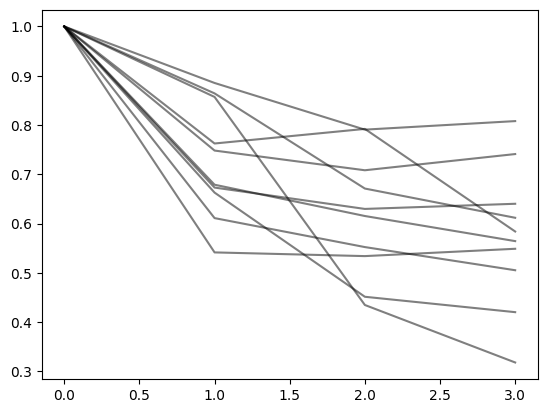

In [49]:
for seed in range(Nseed):
    plt.plot(corr_tot[:,seed],'k', alpha = .5)

## figure

In [50]:
Nseed = 10

In [51]:
#V_list = np.load('V_list.npy')

In [52]:
V_list_shuffled = np.copy(V_list)

In [53]:
V_list_shuffled.shape

(4, 50, 10)

In [54]:
for seed in range(Nseed):
    for day in range(4):
        np.random.shuffle(V_list_shuffled[day,:,seed])

In [55]:
V_list[:,0,0]

array([0.00199647, 0.00188649, 0.00189645, 0.00183639])

In [56]:
V_list_shuffled[:,0,0]

array([1.59221706e-03, 7.78591628e-04, 8.31971590e+00, 7.08480451e-04])

In [57]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])
        
corr_tot_shuffled = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot_shuffled[day,seed] = correlation(V_list_shuffled[0,:,seed],V_list_shuffled[day,:,seed])

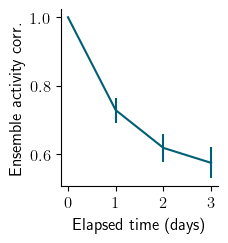

In [58]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

ax.errorbar([0,1,2,3], np.mean(corr_tot,axis=1),stats.sem(corr_tot,axis = 1), color = color[1])
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr.pdf')

# Ordinal time decoder, run different E, get t_mat

In [59]:
V_list = np.zeros([4,N])
V_list[0,:] = np.arange(N)
V_list_suffled = np.copy(V_list)
for i in range(N):
    #print(V_list[:,i])
    line = np.copy(V_list[:,i])
    #print(line)
    np.random.shuffle(line)
    V_list_suffled[:,i] = line
    #print(V_list_suffled[:,i])

In [60]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))
#print(L)

In [61]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [62]:
seedL = range(10)
EL = np.arange(0,3.5,.5)
#EL = [1]
Nseed = len(seedL)

In [ ]:
t_mat = []
t_mat_shuffled = []
V_list = np.zeros([4,N,Nseed])
V_list_suffled = np.zeros([4,N])
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]

    
    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V

    np.save("V_list.npy", V_list)

    # decoder ordinal
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            #print(V[perm[i],:])
            s += correlation(V[perm[i],:],V[perm[i+1],:])
        s = s
        s_corr.append(s)
    #print(s_corr)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    # shuffle
    
    #V_list_suffled = np.copy(V_list[:,:,seed])
    #np.random.shuffle(V_list_suffled.T)
    for i in range(N):
        line = np.copy(V[:,i])
        np.random.shuffle(line)
        V_list_suffled[:,i] = line
    
    #print(V_list[:,:,seed] == V_list_suffled)

    #print(V_list)
    #print(V_list_suffled)
    
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list_suffled[perm[i],:],V_list_suffled[perm[i+1],:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_shuffled.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    #plot_all()
    #plt.savefig(str(E)+'all.pdf')

    plt.show()
    




In [4823]:
#np.save("t_mat_control.npy", t_mat)
#np.save("t_mat_shuffled_control.npy", t_mat_shuffled)

In [34]:
#t_mat = np.load("t_mat_control.npy")
#t_mat_shuffled = np.load("t_mat_shuffled_control.npy")

In [37]:
t_mat = np.array(t_mat).reshape((len(EL),len(decayL),len(seedL)))
t_mat_shuffled = np.array(t_mat_shuffled).reshape((len(EL),len(decayL),len(seedL)))

decay = 0
#t_mat = np.abs(t_mat[:,decay,:])
#t_mat_shuffled = np.abs(t_mat_shuffled[:,decay,:])
t_mat = t_mat[:,decay,:]
t_mat_shuffled = t_mat_shuffled[:,decay,:]

In [38]:
lab = [str(round(idx,2)) for idx in EL]


In [39]:
t_mat_shuffled

array([[ 0.92688305,  1.0319732 ,  0.25501253, -1.00073569, -1.79494966,
         1.56172108,  0.48867086,  1.29707207,  1.12710684, -1.01041739],
       [ 0.68816132, -1.41982026,  0.99987431, -0.59623374,  1.00831584,
        -0.99316883,  0.20065636,  1.86627124,  1.32135663,  0.33818206],
       [ 0.00272822, -1.97028618,  0.99957283, -1.34730217, -0.23341243,
         1.42948947, -1.03269469,  1.01120997, -0.92127177,  0.70514153],
       [ 1.04656824, -1.06639304,  1.49194877, -0.5932922 ,  0.81964072,
         0.58899999, -0.20203963, -0.79036205, -0.4078391 ,  1.4732748 ],
       [ 1.46242775, -1.29423017, -1.10737523, -0.26681115,  0.77771552,
        -0.12311948, -1.36225716, -1.38368569,  0.93659027,  0.48890759],
       [ 1.6557748 ,  0.47668804, -1.39254209,  1.1837746 , -0.65897836,
         1.29018094, -1.55301628,  1.04616115,  0.16745976, -0.43995855],
       [-0.9948051 ,  0.64046853, -1.61445633,  0.41507078,  0.99056135,
         1.46899478, -1.63704856,  1.0462165 

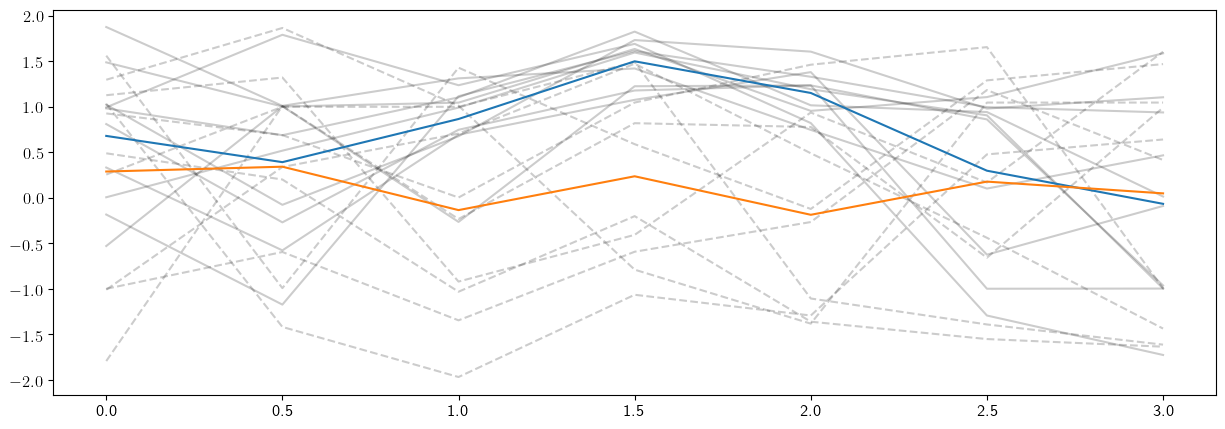

In [40]:
Nseed = len(seedL)
plt.figure(figsize = (15,5))
for seed in range(Nseed):
    plt.plot(t_mat[:,seed],'k', alpha = .2)
    
for seed in range(Nseed):
    plt.plot(t_mat_shuffled[:,seed],'--k', alpha = .2)
    
plt.plot(np.mean(t_mat,axis = 1))
plt.plot(np.mean(t_mat_shuffled,axis = 1))
plt.xticks(range(len(EL)),lab);

## figure

In [42]:
EL = [0,.5,1,1.5,2,2.5,3]
Nseed = len(seedL)

In [43]:
#np.save("t_mat.npy", t_mat)
#np.save("t_mat_shuffled.npy", t_mat_shuffled)
#t_mat = np.load("t_mat.npy")
#t_mat_shuffled = np.load("t_mat_shuffled.npy")

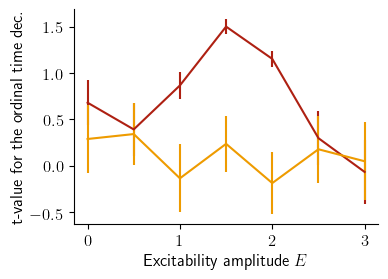

In [44]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(90*mm,70*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat,axis = 1),stats.sem(t_mat,axis = 1),color = "#ae2012")
ax.errorbar(EL,np.mean(t_mat_shuffled,axis = 1),stats.sem(t_mat_shuffled,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('tVSE.pdf',dpi = 1000)



## figure

run firt simulation with E = 1.5

In [66]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))

In [61]:
#np.save("V_list.npy", V_list)
#V_list = np.load('V_list.npy')

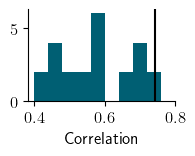

In [62]:
# Ordinal time decoder
decod = []
all_corr_simple = np.zeros((Nseed,len(L)))
for seed in range(Nseed):
    s_corr = []
    p = 0
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list[perm[i],:,seed],V_list[perm[i+1],:,seed])
        s = s/3
        all_corr_simple[seed,p] = s
        p+=1

        
        

seed = 2


mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,30*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.75,.78])


bins = np.arange(.4,.78,.04)
ax.hist(all_corr_simple[seed,:].flatten(),color = color[1], alpha = 1,bins = bins)
ax.axvline(np.mean(all_corr_simple[seed,0]),color = 'k')
#ax.set_ylabel('Count for the ordinal time decoder')
ax.set_xlabel('Correlation')

ax.set_xticks([.4,.6,.8])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('hist.pdf')

In [63]:
bins

array([0.4 , 0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76])

In [64]:
all_corr_simple[seed,0]

0.7421287293924345

# Time decoder

In [67]:
threshold = 5

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [68]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [69]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:3500] = E
    Emat[20:30,3500:6500] = E
    Emat[30:40,6500:9500] = E
    Emat[40:50,9500:12500] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


In [70]:
# main function
def f(yt,t,tag,dt):
    
    global theta
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))

    if t > pause + Nstim*stim + duration + delay*(Nevent-1):
        dWdt = np.zeros((N,N))
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
            
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten()))

    return dydt

In [72]:
Nseed = 10
V_list = np.zeros([Nseed,2,4,N])
for seed in range(Nseed):
    print(seed)
    np.random.seed(seed)
    
    for day in range(4):
        nstep = 14000
        dt = 1
        IN = 15
        Nstim = 10
        stim = 200
        duration = 100
        pause = 1000
        delay = 3000

        seq = []
        Nevent = day + 1

        for ev in range(Nevent):

            for i in range(Nstim):
                seq.append(pause + i*stim + delay*ev)
                seq.append(pause + i*stim + duration + delay*ev)

        seq.append(13000)
        seq.append(13000 + duration)

        def INPUT(t):
            L = 0
            pol = 1
            for step in seq:
                L += np.tanh(t-step)*pol
                pol *= -1
            return IN * np.ones(N)*L/2 + 1




        ############ RUN ##############



         # initialisation
        r0 = np.zeros(N)
        W0 = np.zeros(N*N)
        exc0 = np.zeros(N)
        exc0 = np.random.normal(0,sigma,N)
        exc0 = np.sqrt(exc0*exc0)
        #exc0 = np.random.uniform(0,sigma,N)
        theta0 = np.zeros(N)

        Emat = def_Emat(E,exc0)

        # run
        y = run(INPUT)
        exc = y[index[2][:],:]
        r = y[index[0][:],:]
        theta = y[index[3][:],:]

        V_list[seed,0,day,:] =  r[:,pause + Nstim*stim + delay*day - 100]
        V_list[seed,1,day,:] =  r[:,13100]

        #plot_all()
        


0
1
2
3
4
5
6
7
8
9


In [73]:
decod = np.zeros((Nseed,4))
for seed in range(Nseed):
    for day in range(4):
        corr = []
        for day_try in range(4):
            corr.append(correlation(V_list[seed,0,day,:],V_list[seed,1,day_try,:]))
    
        decod[seed,day] = np.where(corr == np.max(corr))[0]
decod

array([[0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.],
       [0., 1., 2., 3.]])

In [74]:
V_list_shuffled = np.copy(V_list)

decod_shuffled = np.zeros((Nseed,4))
for seed in range(10):
    V = np.copy(V_list_shuffled[seed,1,:,:])
    np.random.shuffle(V)
    V_list_shuffled[seed,1,:,:] = V
    
    for day in range(4):
        corr = []
        for day_try in range(4):
            corr.append(correlation(V_list_shuffled[seed,1,day,:],V_list_shuffled[seed,0,day_try,:]))
        #print(corr)
        decod_shuffled[seed,day] = np.where(corr == np.max(corr))[0]
decod_shuffled

array([[3., 0., 2., 1.],
       [2., 3., 0., 1.],
       [1., 2., 0., 3.],
       [2., 1., 3., 0.],
       [2., 1., 3., 0.],
       [3., 2., 0., 1.],
       [2., 0., 3., 1.],
       [0., 3., 2., 1.],
       [2., 1., 0., 3.],
       [2., 1., 3., 0.]])

In [75]:
error = np.zeros([Nseed,4])
error_shuffled = np.zeros([Nseed,4])
for seed in range(Nseed):
    error[seed,:] = decod[seed,:] - np.arange(4)
    error_shuffled[seed,:] = decod_shuffled[seed,:] - np.arange(4)

## figure

In [76]:
#np.save("error.npy", error)
#np.save("error_shuffled.npy", error_shuffled)
#error = np.load('error.npy')
#error_shuffled = np.load('error_shuffled.npy')

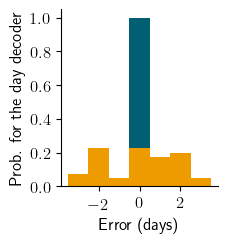

In [77]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])


ax.hist(error.flatten(),bins = np.arange(-3.5,4.5,1),density = True, color = color[1], alpha = 1)
ax.hist(error_shuffled.flatten(),bins = np.arange(-3.5,4.5,1),density = True, color = color[5], alpha = 1)
#plt.legend(['real','shuffled'])
ax.set_ylabel('Prob. for the day decoder')
ax.set_xlabel('Error (days)')
ax.set_xticks([-2,0,2])
ax.set_yticks([0,.2,.4,.6,.8,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('time_decoder.pdf')


# Memory decoder

In [234]:
def run(INPUT):
    global theta
    theta = 0
    global step
    step = 0
    thetaL = np.zeros((N,1))
    y0 = np.concatenate((r0,W0,exc0,theta0,Wout0,rout0,thetaout0))
    y = np.zeros((len(y0),nstep))
    routbis = np.zeros((4,nstep))
    tag = 0
    y[:,0] = y0
    
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,tag,dt)[np.newaxis]);
    return y


In [235]:
# main function
routbis = np.zeros((4,nstep))
S = []
def f(yt,t,tag,dt):
    
    global theta
    global routbis
    global routbis_shuffled
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    Wout = yt[index[4]].reshape((1,N))
    #rout = yt[index[5]][np.newaxis].T
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T
    thetaout = yt[index[6]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=1,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
    
    
    rout = Wout.dot(r)[0]
    routbis[0,t] = rout
    dWoutdt = (1 - np.sum(Wout))*r.T * rout/200 - Wout/1000
    #dWoutdt = r.T * rout/1000 - Wout/1000
    #dWoutdt = (rout * (rout-thetaout) * r.T )/ 4000
    #dWoutdt = np.multiply(dWoutdt,Wout<10)
    dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout<=0,dWoutdt<0)))
    #dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout>=10,dWoutdt>0)))
    #droutdt = (Wout.dot(r) - rout) /1
    #dthetaoutdt = ((rout*rout)/.2 - thetaout)/10
    dthetaoutdt = np.zeros((1))
    droutdt = np.zeros((1))
    S.append(np.sum(Wout))
    
    if t > 3000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[1,t] = Wout.dot(r)[0]

    if t > 6000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[2,t] = Wout.dot(r)[0]
        
    if t > 9000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[3,t] = Wout.dot(r)[0]
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten(),
                           dWoutdt.flatten(),
                           droutdt.flatten(),
                           dthetaoutdt.flatten()))

    return dydt

In [236]:
N = 50
I0 = 5
I1 = 1
E = 5
#taus = 2000

taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)
rout0 = np.zeros(1)
Wout0 = np.zeros(N) + .001
thetaout0 = np.zeros(1)

nstep = 13000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000

seq = []
Nevent = 4
for ev in range(Nevent):

    for i in range(Nstim):
        seq.append(pause + i*stim + delay*ev)
        seq.append(pause + i*stim + duration + delay*ev)
    
def INPUT(t):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * np.ones(N)*L/2 + 1

index = [range(0,N),
         range(N,N + N*N),
         range(N + N*N,N + N*N +N),
         range(N + N*N +N,N + N*N+N+N),
         range(N + N*N +N+N,N + N*N +N+N+N),
         range(N + N*N +N+N+N,N + N*N +N+N+N+1),
         range(N + N*N +N+N+N+1,N + N*N +N+N+N+1+1)]
         
         
         
         
         

In [237]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:3500] = E
    Emat[20:30,3500:6500] = E
    Emat[30:40,6500:9500] = E
    Emat[40:50,9500:] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


In [238]:
threshold = 5

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
#EL = [3]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = [2]

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [239]:
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)

exc0

array([0.53203137, 1.07922682, 0.23735219, 0.56649053, 0.31946118,
       0.88072847, 0.91345311, 0.65237871, 0.76376465, 0.79265285,
       0.77868806, 1.15448316, 0.4135975 , 3.15748836, 0.29138696,
       0.47980025, 0.03368503, 0.06114845, 0.75087035, 0.86729313,
       1.1943921 , 0.44595435, 0.76072248, 1.01117398, 0.05442112,
       0.08068257, 1.06539043, 0.32419124, 0.53302273, 0.32618072,
       0.53600836, 0.58965383, 0.61062642, 0.76352983, 0.49420285,
       1.93502251, 1.2565247 , 0.22248125, 1.67244928, 0.09890018,
       1.32358733, 0.69881497, 1.75516332, 1.45363399, 0.18067817,
       0.65841085, 0.64895462, 0.06056086, 0.20646152, 1.00812094])

(800, 20, 100, 12, 0.5, 1.5, 2, 1, 1000, 15, 2)


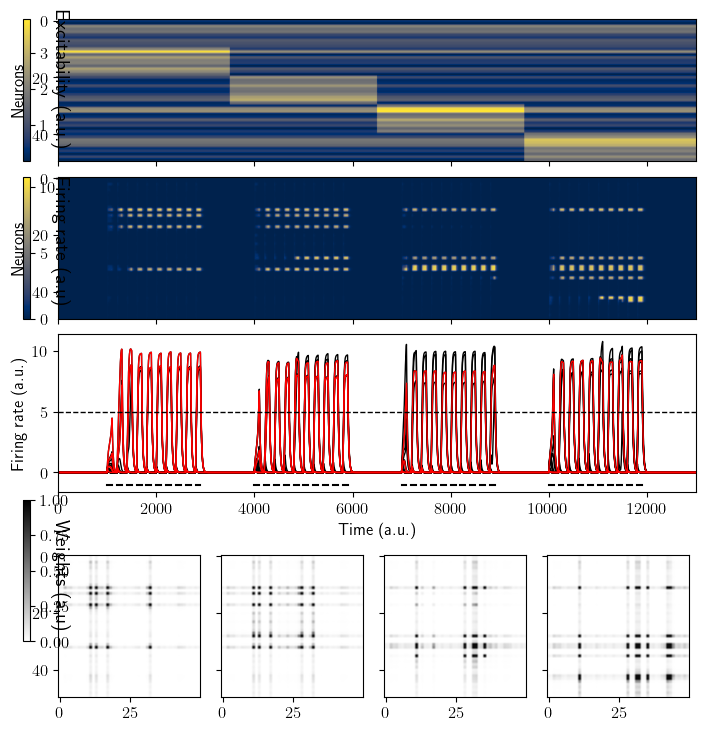

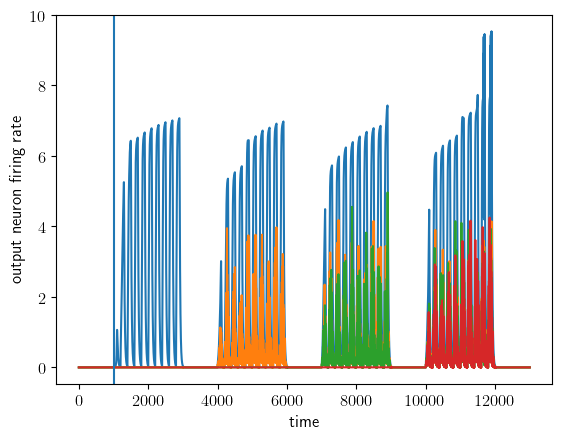

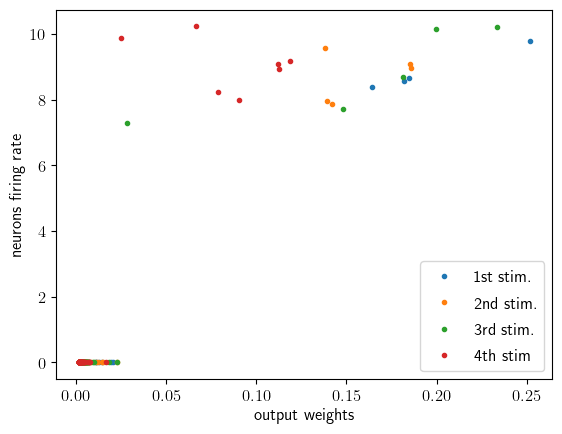

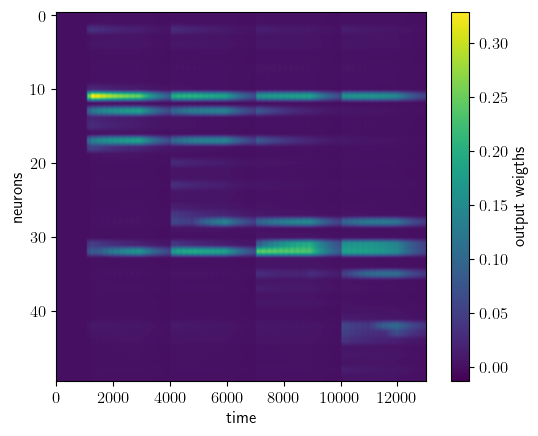

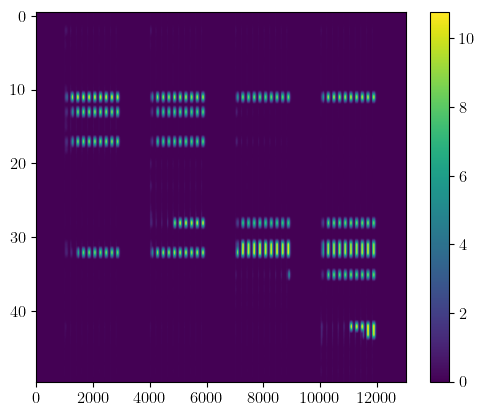

In [78]:
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    rout = y[index[5][:],:] 
    
    
    plot_all()
    #plt.savefig('all.pdf')

    plt.show()
    
    
    # decode memory rate
    plt.figure()
    plt.plot(routbis[0,:]);
    plt.plot(routbis[1,:]);
    plt.plot(routbis[2,:]);
    plt.plot(routbis[3,:]);
    plt.xlabel('time')
    plt.ylabel('output neuron firing rate')
    plt.axvline(x = 1000)
    plt.savefig('decode_rate.png',dpi = 500)
    plt.show()

    # weights vs rates
    for t in [2900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [5900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [8900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [11900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    plt.legend(['1st stim.','2nd stim.','3rd stim.','4th stim'])
    plt.xlabel('output weights')
    plt.ylabel('neurons firing rate')
    plt.savefig('decode_corr.png',dpi = 500)
    plt.show()

    
    # weights
    plt.figure()
    plt.imshow(Wout,aspect = nstep/N)
    cbar = plt.colorbar()
    cbar.set_label('output weigths')
    plt.ylabel('neurons')
    plt.xlabel('time')
    plt.savefig('weights.png',dpi = 500)
    plt.show()

    # rates
    plt.figure()
    plt.imshow(r,aspect = nstep/N)
    plt.colorbar()
    plt.show()





## figure

In [79]:
threshold = 5

In [80]:
active = r[:,2850]>threshold

In [81]:
active = np.where(active)[0]

In [82]:
L = np.array(range(N))
for l in active:
    L = np.delete(L,l)

In [83]:
L = [i for i in range(N) if i not in active]

In [84]:
active

array([11, 13, 17, 32])

In [85]:
cmap = reversed(["20331a","33512a","446c37","558745","66a253","7cb36b","94c186","abcea1","c3dcbc","dbead7"])
cmap2 = ["ffffff","005F73"]

In [86]:
import matplotlib.colors as mcolors
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

cmap = get_continuous_cmap(cmap)
cmap2 = get_continuous_cmap(cmap2)

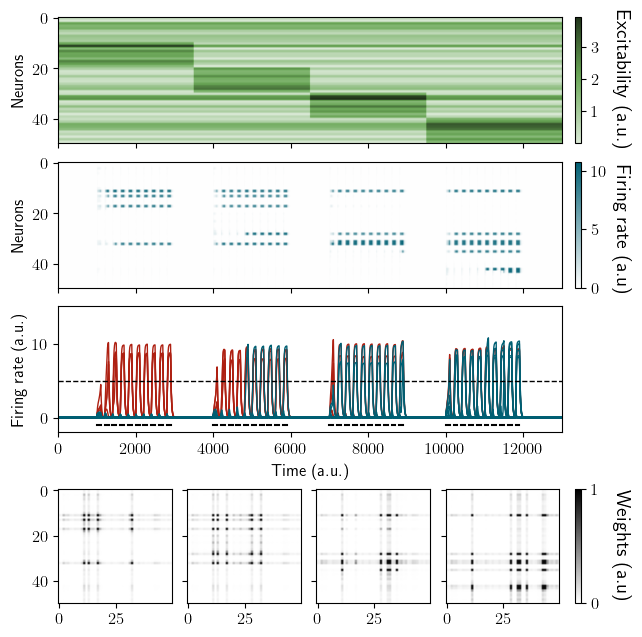

In [87]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(160*mm,160*mm), facecolor='w',frameon=False)

ax1 = fig.add_axes([.04,.79,.88,.2]) # [left, bottom, width, height] 
ax2 = fig.add_axes([.04,.56,.88,.2])
ax3 = fig.add_axes([.08,.33,.8,.2])

w = .18
ax5 = fig.add_axes([.08,.06,w,w])
ax6 = fig.add_axes([.285,.06,w,w])
ax7 = fig.add_axes([.49,.06,w,w])
ax8 = fig.add_axes([.695,.06,w,w])


im = ax1.imshow(Emat,aspect = nstep/N*2/8,cmap = cmap)
ax1.set_ylabel('Neurons')
ax1.set_xticklabels('')
cbar1 = plt.colorbar(im,cax = plt.axes([.9, 0.79, 0.01, 0.2])) # [left, bottom, width, height] 
cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=-.09,x=6)

im = ax2.imshow(np.maximum(0,r),aspect = nstep/N*2/8,cmap = cmap2)
ax2.set_ylabel('Neurons')
ax2.set_xticklabels('')
cbar2 = plt.colorbar(im,cax = plt.axes([.9, 0.56, 0.01, 0.2])) # [left, bottom, width, height] 
cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=-.09,x=6)

for n in active:
    ax3.plot(r[n,:],color[8],linewidth = 1)
for n in L:
    ax3.plot(r[n,:],color[1],linewidth = 1)


ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
ax3.set_xlabel('Time (a.u.)')
ax3.set_ylabel('Firing rate (a.u.)')

ax3.set_xlim([0,nstep])
ax3.set_ylim([-2,15])

h = -1
for s in range(int(len(seq)/2)):
    ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')


im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax6.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax7.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax8.imshow(y[index[1][:],12000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
ax6.set_yticklabels('')
ax7.set_yticklabels('')
ax8.set_yticklabels('')

cbar3 = plt.colorbar(im,cax = plt.axes([.9, 0.06, 0.01, 0.18]))
cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=-.02,x=6)
cbar3.set_ticks([0,1])
plt.savefig('all.pdf')

## figure

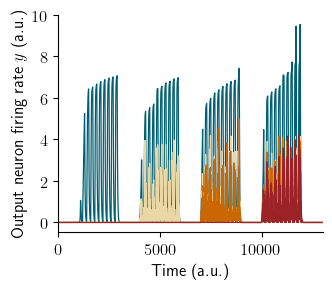

In [88]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(80*mm,70*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.16,0.18,.84,.79])

lw = .9
ax.plot(routbis[0,:],color[1],linewidth=lw);
ax.plot(routbis[1,:],color[4],linewidth=lw);
ax.plot(routbis[2,:],color[6],linewidth=lw);
ax.plot(routbis[3,:],color[9],linewidth=lw);

#plt.yscale('log')
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Output neuron firing rate $y$ (a.u.)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,13000])
plt.savefig('decode_rate.pdf')




## figure

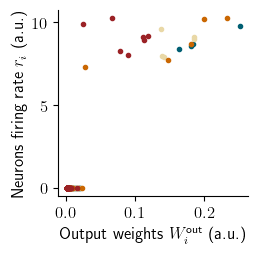

In [89]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(70*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


for t in [2900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[1])
for t in [5900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[4])
for t in [8900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[6])
for t in [11900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[9])

ax.set_xlabel(r'Output weights $W^{\text{out}}_i$ (a.u.)')
ax.set_ylabel(r'Neurons firing rate $r_i$ (a.u.)')
ax.set_yticks([0,5,10])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr.pdf')

## figure

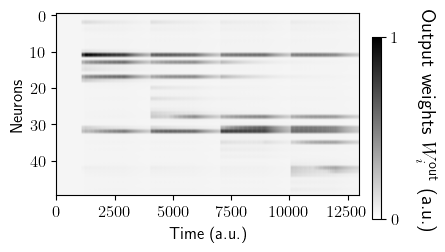

In [90]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(110*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.12,0.2,.7,.77])


ax.imshow(Wout, aspect='auto', cmap = 'binary')
cbar3 = plt.colorbar(im,cax = plt.axes([.85, 0.1, 0.02, 0.77]))
cbar3.ax.set_title(r'Output weights $W^{\text{out}}_i$ (a.u.)', rotation=270,loc='left',y=-.1,x=5)
cbar3.set_ticks([0,1])


ax.set_ylabel('Neurons')
ax.set_xlabel('Time (a.u.)')

plt.savefig('weights.pdf')

## figure


In [91]:
for t in [2900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[1])
for t in [5900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[4])
for t in [8900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[6])
for t in [11900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[9])

In [92]:
W1 = Wout[:,2900]
W2 = Wout[:,5900]
W3 = Wout[:,8900]
W4 = Wout[:,11900]

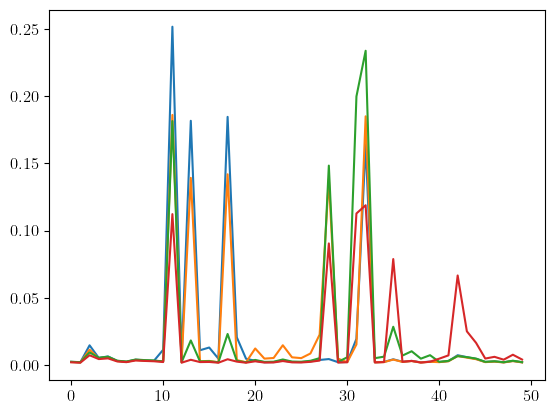

In [93]:
plt.plot(W1)
plt.plot(W2)
plt.plot(W3)
plt.plot(W4)

In [94]:
seedL = range(10)
WoutL = np.zeros((len(seedL),4))
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    
    W1 = Wout[:,2950]
    W2 = Wout[:,5950]
    W3 = Wout[:,8950]
    W4 = Wout[:,11950]

    WoutL[seed,:] = np.array([sum(np.multiply(W1,pos))/np.sum(W1),sum(np.multiply(W2,pos))/np.sum(W2),sum(np.multiply(W3,pos))/np.sum(W3),sum(np.multiply(W4,pos))/np.sum(W4)])
    

(800, 20, 100, 12, 0.5, 1.5, 2, 1, 1000, 15, 0)
(800, 20, 100, 12, 0.5, 1.5, 2, 1, 1000, 15, 1)
(800, 20, 100, 12, 0.5, 1.5, 2, 1, 1000, 15, 2)
(800, 20, 100, 12, 0.5, 1.5, 2, 1, 1000, 15, 3)
(800, 20, 100, 12, 0.5, 1.5, 2, 1, 1000, 15, 4)
(800, 20, 100, 12, 0.5, 1.5, 2, 1, 1000, 15, 5)
(800, 20, 100, 12, 0.5, 1.5, 2, 1, 1000, 15, 6)
(800, 20, 100, 12, 0.5, 1.5, 2, 1, 1000, 15, 7)
(800, 20, 100, 12, 0.5, 1.5, 2, 1, 1000, 15, 8)
(800, 20, 100, 12, 0.5, 1.5, 2, 1, 1000, 15, 9)


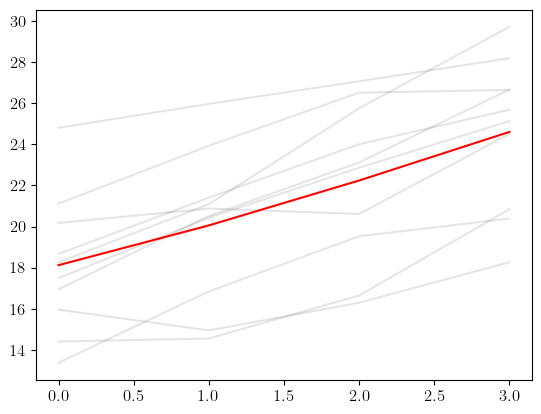

In [95]:
for i in range(10):
    plt.plot(WoutL[i,:],'k',alpha=.1)
plt.plot(np.mean(WoutL,axis=0),'r')

In [96]:
WoutLshuffled = np.copy(WoutL)
np.random.shuffle(WoutLshuffled.T)

In [97]:
WoutL

array([[17.49257607, 20.4285759 , 22.86429679, 25.13155314],
       [14.40174781, 14.54923554, 16.64379676, 20.844825  ],
       [18.25751287, 21.08479813, 25.75557761, 29.72753058],
       [16.94720376, 20.51467988, 23.11921726, 26.66881198],
       [21.11659641, 23.93136086, 26.51740361, 26.65132357],
       [15.95611376, 14.9454361 , 16.29258539, 18.26462551],
       [13.37108715, 16.83831982, 19.52695334, 20.38952199],
       [24.80517821, 25.97208024, 27.0709914 , 28.19430913],
       [20.17723009, 20.87520975, 20.61283156, 24.50767559],
       [18.66552831, 21.40822023, 24.00767141, 25.68450488]])

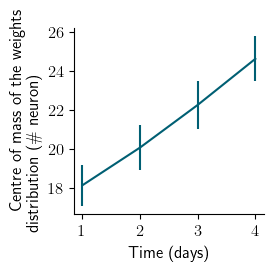

In [98]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(70*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


ax.errorbar([1,2,3,4],np.mean(WoutL,axis=0),stats.sem(WoutL),color = color[1])


ax.set_xlabel(r'Time (days)')
ax.set_ylabel(r'Centre of mass of the weights \newline distribution (\# neuron)')
#ax.set_yticks([0,5,10])
ax.set_xticks([1,2,3,4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr.pdf')



## Revision: read-out vs drift rate

In [101]:
seedL = range(100)
Nshuffle = 10

corrL = np.zeros((len(seedL),4))
routL = np.zeros((len(seedL),4))
rout_shuffleL = np.zeros((len(seedL),Nshuffle,4))
rout_init_shuffle = np.zeros((len(seedL),Nshuffle,4))
rout_init = np.zeros((len(seedL),4))

CoML = np.zeros((len(seedL),4))
pos = np.array(range(N))

In [102]:
for seed in seedL:
    print(seed)
    for shuffle in range(Nshuffle):
        
        routbis = np.zeros((4,nstep))
        
         # initialisation
        np.random.seed(seed)
        r0 = np.zeros(N)
        W0 = np.zeros(N*N)
        exc0 = np.zeros(N)
        exc0 = np.random.normal(0,sigma,N)
        exc0 = np.sqrt(exc0*exc0)
        #exc0 = np.random.uniform(0,sigma,N)
        theta0 = np.zeros(N)

        Emat = def_Emat(E,exc0)

        # run
        np.random.seed(100*(seed+1) + shuffle)
        y = run(INPUT)
        exc = y[index[2][:],:]
        r = y[index[0][:],:]
        theta = y[index[3][:],:]
        Wout = y[index[4][:],:]

        V0 = r[:,2900]
        V1 = r[:,5900]
        V2 = r[:,8900]
        V3 = r[:,11900]
        rout_0 = Wout[:,2900].reshape((1,N)).dot(V0)[0]
        rout_1 = Wout[:,5900].reshape((1,N)).dot(V1)[0]
        rout_2 = Wout[:,8900].reshape((1,N)).dot(V2)[0]
        rout_3 = Wout[:,11900].reshape((1,N)).dot(V3)[0]
        
        routL[seed,:] = [rout_0,rout_1,rout_2,rout_3]

        corrL[seed,:] = [correlation(V0,V0),correlation(V0,V1),correlation(V0,V2),correlation(V0,V3)]
        W1 = Wout[:,2900]
        W2 = Wout[:,5900]
        W3 = Wout[:,8900]
        W4 = Wout[:,11900]
        CoML[seed,:] = [sum(np.multiply(W1,pos))/np.sum(W1),sum(np.multiply(W2,pos))/np.sum(W2),sum(np.multiply(W3,pos))/np.sum(W3),sum(np.multiply(W4,pos))/np.sum(W4)]

        rout_shuffleL[seed,shuffle,:] = [np.mean(routbis[0,:]),np.mean(routbis[1,:]),np.mean(routbis[2,:]),np.mean(routbis[3,:])]
        
        rout_init_shuffle[seed,shuffle,:] = [routbis[0,1100],
                                             routbis[1,4100],
                                             routbis[2,7100],
                                             routbis[3,10100]]
        
        rout_init[seed,:] = [Wout[:,1100].reshape((1,N)).dot(r[:,1100])[0],
                            Wout[:,4100].reshape((1,N)).dot(r[:,4100])[0],
                            Wout[:,7100].reshape((1,N)).dot(r[:,7100])[0],
                            Wout[:,10100].reshape((1,N)).dot(r[:,10100])[0]]
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [103]:
#np.save('corrL.npy', corrL)
#np.save('routL.npy', routL)
#np.save('rout_shuffleL.npy', rout_shuffleL)
#np.save('rout_init_shuffle.npy', rout_init_shuffle)
#np.save('rout_init.npy', rout_init)
#np.save('CoML.npy', CoML)


#corrL = np.load('corrL.npy', )
#routL = np.load('routL.npy', )
#rout_shuffleL = np.load('rout_shuffleL.npy', )
#rout_init_shuffle = np.load('rout_init_shuffle.npy', )
#rout_init = np.load('rout_init.npy', )
#CoML = np.load('CoML.npy', )

In [104]:
rout_shuffle_mean = np.mean(rout_shuffleL,axis = 1)
rout_init_shuffle_mean = np.mean(rout_init_shuffle,axis = 1)

In [105]:
# AVG on shuffle and all time + ratio 
#r_normed = np.zeros((100,4))
#for seed in range(100):
#    for day in range(4):
#        r_normed[seed,day] = rout_shuffle_mean[seed,0]/rout_shuffle_mean[seed,1]
        
# AVG on shuffle + ratio
#r_normed = np.divide(rout_init,rout_init_shuffle_mean)

# AVG on shuffle + contrast
#r_normed = np.divide(rout_init - rout_init_shuffle_mean,rout_init + rout_init_shuffle_mean)

# AVG on shuffle + difference
#r_normed = rout_init - rout_init_shuffle_mean

# ... + AVG on shuffle
r_normed = np.zeros((len(seedL),Nshuffle,4))
for s in range(Nshuffle):
    # ratio ...
    r_normed[:,s,:] = np.divide(rout_init,rout_init_shuffle[:,s,:])
    # contrast ...
    #r_normed[:,s,:] = np.divide(rout_init-rout_init_shuffle[:,s,:],rout_init+rout_init_shuffle[:,s,:])
    # difference ... (same as AVG + difference)
    #r_normed[:,s,:] = rout_init-rout_init_shuffle[:,s,:]
r_normed = np.mean(r_normed,axis = 1)

drift = np.sum(1-corrL[:,:],1)
drift2= np.max(1-corrL,1)

In [106]:
X = np.sum(1-corrL[:,0:],1).reshape(-1,1)
Y = np.sum(r_normed[:,0:],axis = 1)
X = np.sum(1-corrL[:,1:],1).reshape(-1,1)
Y = np.sum(r_normed[:,1:],axis = 1)


In [107]:
reg = LinearRegression().fit(X,Y)

r = reg.score(X, Y)
a = reg.coef_[0]
b = reg.intercept_

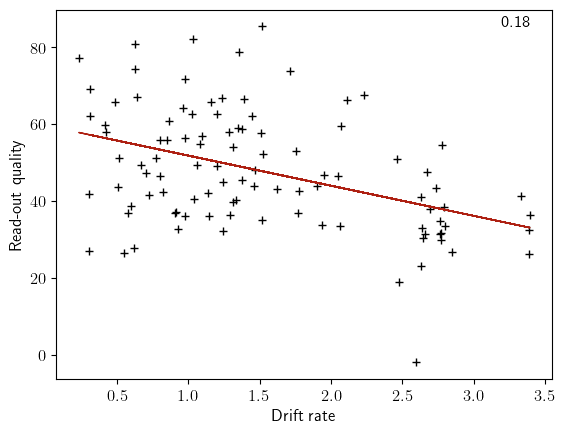

In [108]:
plt.plot(X,Y,'+',color = 'k')
plt.plot(X,a * X + b,color = '#AE2012',linewidth = 1)
plt.xlabel('Drift rate')
plt.ylabel('Read-out quality')
plt.text(max(X)*.94,max(Y),str(round(r,3)));
plt.savefig('readVSdrift.pdf')

## Revision: read-out vs E

In [113]:
seedL = range(10)
Nshuffle = 10
EL = [0,.5,1,1.5,2,2.5,3]

corrL = np.zeros((len(seedL),4,len(EL)))
routL = np.zeros((len(seedL),4,len(EL)))
rout_shuffleL = np.zeros((len(seedL),Nshuffle,4,len(EL)))
rout_init_shuffle = np.zeros((len(seedL),Nshuffle,4,len(EL)))
rout_init = np.zeros((len(seedL),4,len(EL)))
CoML = np.zeros((len(seedL),4,len(EL)))

pos = np.array(range(N))

In [ ]:
for c in range(len(EL)):
    E = EL[c]
    for seed in seedL:
        print([E,seed])
        for shuffle in range(Nshuffle):
            routbis = np.zeros((4,nstep))

             # initialisation
            np.random.seed(seed)
            r0 = np.zeros(N)
            W0 = np.zeros(N*N)
            exc0 = np.zeros(N)
            exc0 = np.random.normal(0,sigma,N)
            exc0 = np.sqrt(exc0*exc0)
            #exc0 = np.random.uniform(0,sigma,N)
            theta0 = np.zeros(N)

            Emat = def_Emat(E,exc0)

            # run
            np.random.seed(100*(seed+1) + shuffle)
            y = run(INPUT)
            exc = y[index[2][:],:]
            r = y[index[0][:],:]
            theta = y[index[3][:],:]
            Wout = y[index[4][:],:]

            V0 = r[:,2900]
            V1 = r[:,5900]
            V2 = r[:,8900]
            V3 = r[:,11900]
            rout_0 = Wout[:,2900].reshape((1,N)).dot(V0)[0]
            rout_1 = Wout[:,5900].reshape((1,N)).dot(V1)[0]
            rout_2 = Wout[:,8900].reshape((1,N)).dot(V2)[0]
            rout_3 = Wout[:,11900].reshape((1,N)).dot(V3)[0]

            routL[seed,:,c] = [rout_0,rout_1,rout_2,rout_3]

            corrL[seed,:,c] = [correlation(V0,V0),correlation(V0,V1),correlation(V0,V2),correlation(V0,V3)]
            W1 = Wout[:,2900]
            W2 = Wout[:,5900]
            W3 = Wout[:,8900]
            W4 = Wout[:,11900]
            CoML[seed,:,c] = [sum(np.multiply(W1,pos))/np.sum(W1),sum(np.multiply(W2,pos))/np.sum(W2),sum(np.multiply(W3,pos))/np.sum(W3),sum(np.multiply(W4,pos))/np.sum(W4)]

            rout_shuffleL[seed,shuffle,:,c] = [np.mean(routbis[0,:]),np.mean(routbis[1,:]),np.mean(routbis[2,:]),np.mean(routbis[3,:])]

            rout_init_shuffle[seed,shuffle,:,c] = [routbis[0,1100],
                                                 routbis[1,4100],
                                                 routbis[2,7100],
                                                 routbis[3,10100]]

            rout_init[seed,:,c] = [Wout[:,1100].reshape((1,N)).dot(r[:,1100])[0],
                                Wout[:,4100].reshape((1,N)).dot(r[:,4100])[0],
                                Wout[:,7100].reshape((1,N)).dot(r[:,7100])[0],
                                Wout[:,10100].reshape((1,N)).dot(r[:,10100])[0]]
        

In [ ]:
#np.save('corrL_vsE.npy', corrL)
#np.save('routL_vsE.npy', routL)
#np.save('rout_shuffleL_vsE.npy', rout_shuffleL)
#np.save('rout_init_shuffle_vsE.npy', rout_init_shuffle)
#np.save('rout_init_vsE.npy', rout_init)
#np.save('CoML_vsE.npy', CoML)


#corrL = np.load('corrL_vsE.npy', )
#routL = np.load('routL_vsE.npy', )
#rout_shuffleL = np.load('rout_shuffleL_vsE.npy', )
#rout_init_shuffle = np.load('rout_init_shuffle_vsE.npy', )
#rout_init = np.load('rout_init_vsE.npy', )
#CoML = np.load('CoML_vsE.npy', )

In [ ]:
rout_shuffle_mean = np.mean(rout_shuffleL,axis = 1)
rout_init_shuffle_mean = np.mean(rout_init_shuffle,axis = 1)

In [ ]:
# AVG on shuffle and all time + ratio 
#r_normed = np.zeros((100,4))
#for seed in range(100):
#    for day in range(4):
#        r_normed[seed,day] = rout_shuffle_mean[seed,0]/rout_shuffle_mean[seed,1]
        
# AVG on shuffle + ratio
#r_normed = np.divide(rout_init,rout_init_shuffle_mean)

# AVG on shuffle + contrast
#r_normed = np.divide(rout_init - rout_init_shuffle_mean,rout_init + rout_init_shuffle_mean)

# AVG on shuffle + difference
#r_normed = rout_init - rout_init_shuffle_mean

# ... + AVG on shuffle
r_normed = np.zeros((len(seedL),Nshuffle,4))
for s in range(Nshuffle):
    # ratio ...
    r_normed[:,s,:] = np.divide(rout_init,rout_init_shuffle[:,s,:])
    # contrast ...
    #r_normed[:,s,:] = np.divide(rout_init-rout_init_shuffle[:,s,:],rout_init+rout_init_shuffle[:,s,:])
    # difference ... (same as AVG + difference)
    #r_normed[:,s,:] = rout_init-rout_init_shuffle[:,s,:]
r_normed = np.mean(r_normed,axis = 1)

drift = np.sum(1-corrL[:,:],1)
drift2= np.max(1-corrL,1)

## Revision: change of slope

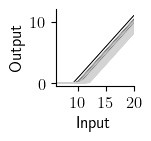

In [147]:
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)

np.random.seed(0)
sigma = 1
E = 1.5
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)

fig, ax = plt.subplots(figsize = (1,1))
lw = .5
X = np.arange(0,21)
for i in range(N):
    Y = np.maximum(0, X + exc0[i] - 12)
    ax.plot(X,Y, color='lightgrey',linewidth=lw)
    if i >=10 and i < 20:
        Y = np.maximum(0, X + exc0[i] + E - 12)
        ax.plot(X,Y, color='k',linewidth=lw)

ax.set_xlabel(r'Input')
ax.set_ylabel(r'Output')
ax.set_xlim([6,20])
ax.set_ylim([-.5,12])
ax.set_xticks([10,15,20])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('th.pdf',bbox_inches='tight')


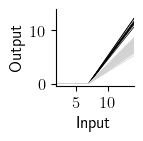

In [157]:
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)

np.random.seed(0)
sigma = .1
E = .6
offset = 5
slope = 1
exc0 = np.zeros(N)
exc0 = np.random.normal(slope,sigma,N)
exc0 = np.sqrt(exc0*exc0)

fig, ax = plt.subplots(figsize = (1,1))
lw = .5
X = np.arange(0,21)
for i in range(N):
    Y = np.maximum(0, X - I0 + offset) * exc0[i]
    ax.plot(X,Y, color='lightgrey',linewidth=lw)
    if i >=10 and i < 20:
        Y = np.maximum(0, X  - I0 + offset) * (exc0[i]+ E)
        ax.plot(X,Y, color='k',linewidth=lw)

ax.set_xlabel(r'Input')
ax.set_ylabel(r'Output')
ax.set_xlim([2,14])
ax.set_ylim([-.5,14])

#ax.set_xticks([5,10,15,20])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('sl.pdf',bbox_inches='tight')


In [158]:
# main function
routbis = np.zeros((4,nstep))
S = []
def f(yt,t,tag,dt):
    
    global theta
    global routbis
    global routbis_shuffled
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    Wout = yt[index[4]].reshape((1,N))
    #rout = yt[index[5]][np.newaxis].T
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T
    thetaout = yt[index[6]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*I2

    drdt = (-r + exc * np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib) )/taur
    #drdt = (-r + np.arctan(exc) * np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib) )/taur
    

    #if t == 2050:
    #    print(W.dot(r) + INPUT(t)[np.newaxis].T - rinhib)
    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=cap ,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
    
    
    rout = Wout.dot(r)[0]
    routbis[0,t] = rout
    dWoutdt = (1 - np.sum(Wout))*r.T * rout/200 - Wout/1000
    #dWoutdt = r.T * rout/1000 - Wout/1000
    #dWoutdt = (rout * (rout-thetaout) * r.T )/ 4000
    #dWoutdt = np.multiply(dWoutdt,Wout<10)
    dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout<=0,dWoutdt<0)))
    #dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout>=10,dWoutdt>0)))
    #droutdt = (Wout.dot(r) - rout) /1
    #dthetaoutdt = ((rout*rout)/.2 - thetaout)/10
    dthetaoutdt = np.zeros((1))
    droutdt = np.zeros((1))
    S.append(np.sum(Wout))
    
    if t > 3000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[1,t] = Wout.dot(r)[0]

    if t > 6000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[2,t] = Wout.dot(r)[0]
        
    if t > 9000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[3,t] = Wout.dot(r)[0]
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten(),
                           dWoutdt.flatten(),
                           droutdt.flatten(),
                           dthetaoutdt.flatten()))

    return dydt

In [163]:
N = 50
I0 = 5
I1 = 1
E = 5
#taus = 2000

taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)
rout0 = np.zeros(1)
Wout0 = np.zeros(N) + .001
thetaout0 = np.zeros(1)

nstep = 13000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000

seq = []
Nevent = 4
for ev in range(Nevent):

    for i in range(Nstim):
        seq.append(pause + i*stim + delay*ev)
        seq.append(pause + i*stim + duration + delay*ev)
    
def INPUT(t):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * np.ones(N)*L/2 + 1

         
index = [range(0,N),
         range(N,N + N*N),
         range(N + N*N,N + N*N +N),
         range(N + N*N +N,N + N*N+N+N),
         range(N + N*N +N+N,N + N*N +N+N+N),
         range(N + N*N +N+N+N,N + N*N +N+N+N+1),
         range(N + N*N +N+N+N+1,N + N*N +N+N+N+1+1)]
         
         
         
         
         

In [164]:
E = 1.5
sigma = 1
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)

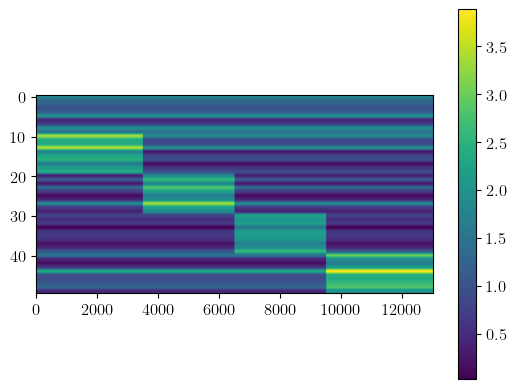

In [165]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:3500] = E
    Emat[20:30,3500:6500] = E
    Emat[30:40,6500:9500] = E
    Emat[40:50,9500:] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

Emat = def_Emat(E,exc0)

plt.figure()
plt.imshow(Emat,aspect = nstep/N/2)
plt.colorbar()

(array([ 5.,  9.,  9., 10.,  4.,  4.,  2.,  4.,  2.,  1.]),
 array([0.03183056, 0.26696198, 0.5020934 , 0.73722482, 0.97235624,
        1.20748767, 1.44261909, 1.67775051, 1.91288193, 2.14801335,
        2.38314477]),
 <a list of 10 Patch objects>)

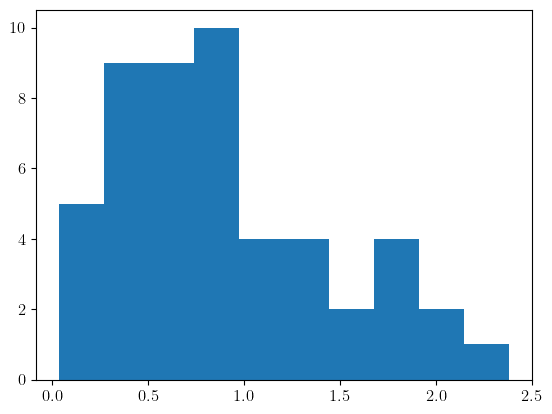

In [166]:
plt.hist(exc0)

### param

In [170]:
threshold = 1
tauwL = [700]
taurL = [20]
tauthetaL = [100]
I0L = [4]
I1L = [.7]
EL = [.5]
y0L = [2]
sigmaL = [.2]
decayL = [800]
INL = [15]
seedL = [0]
slopeL = [.4]
capL = [.5]
I2L = [.05]
(700, 20, 100, 4, 0.7, 1, 2, 0.2, 800, 15, 1, 0.5, 0.6, 0.05)## works ok but not good decay

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope,cap,I2)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0],slopeL[0],capL[0],I2L[0])
# slope = .2

(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 0, 0.4, 0.5, 0.05)


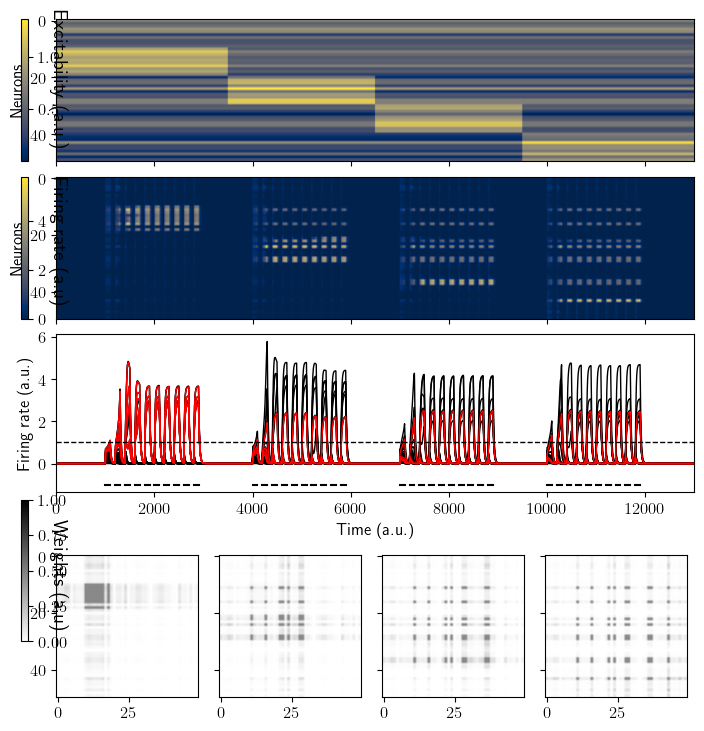

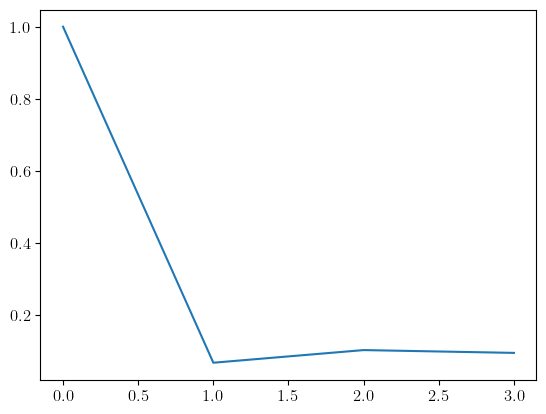

In [171]:
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope,cap,I2) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL,slopeL,capL,I2L):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope,cap,I2))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(slope,sigma,N)
    #exc0 = np.random.uniform(slope-sigma,slope+sigma,N)
    exc0 = np.sqrt(exc0*exc0)


    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    rout = y[index[5][:],:] 
    
    plot_all()
    #plt.savefig('all.pdf')

    plt.show()
    
    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    plt.plot([correlation(V0,V0),correlation(V0,V1),correlation(V0,V2),correlation(V0,V3)])
    plt.show()


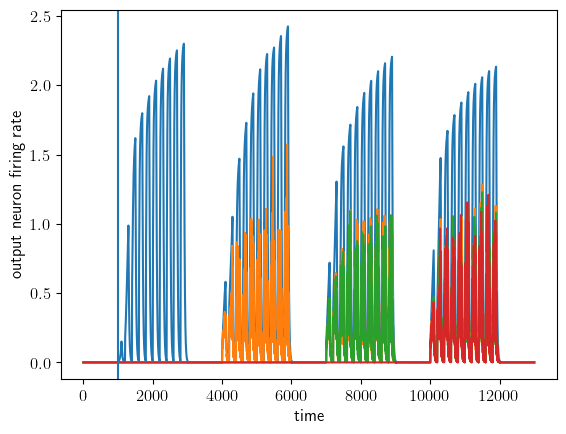

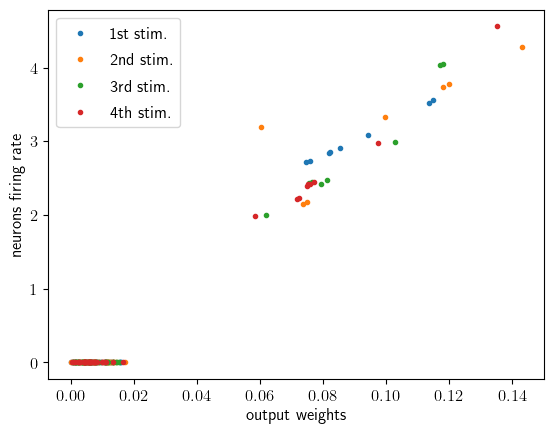

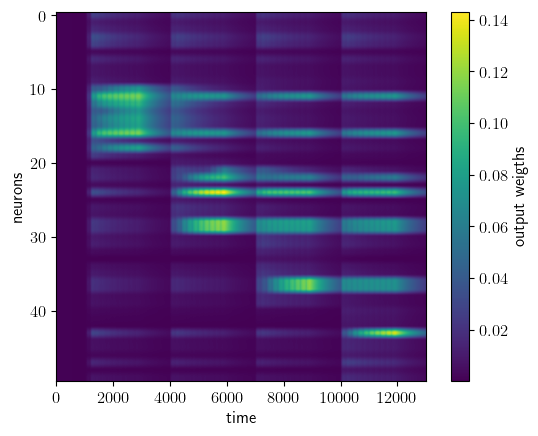

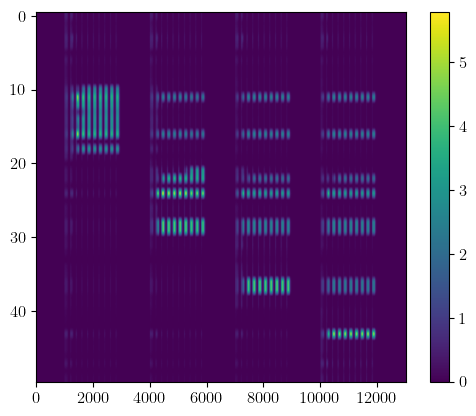

In [172]:
    
    # decode memory rate
    plt.figure()
    plt.plot(routbis[0,:]);
    plt.plot(routbis[1,:]);
    plt.plot(routbis[2,:]);
    plt.plot(routbis[3,:]);
    plt.xlabel('time')
    plt.ylabel('output neuron firing rate')
    plt.axvline(x = 1000)
    plt.savefig('decode_rate.png',dpi = 500)
    plt.show()

    # weights vs rates
    for t in [2900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [5900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [8900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    for t in [11900]:
        plt.plot(Wout[:,t],r[:,t],'.')
    plt.legend(['1st stim.','2nd stim.','3rd stim.','4th stim.'])
    plt.xlabel('output weights')
    plt.ylabel('neurons firing rate')
    plt.savefig('decode_corr.png',dpi = 500)
    plt.show()

    
    # weights
    plt.figure()
    plt.imshow(Wout,aspect = nstep/N)
    cbar = plt.colorbar()
    cbar.set_label('output weigths')
    plt.ylabel('neurons')
    plt.xlabel('time')
    plt.savefig('weights.png',dpi = 500)
    plt.show()

    # rates
    plt.figure()
    plt.imshow(r,aspect = nstep/N)
    plt.colorbar()
    plt.show()

In [173]:
active = r[:,2850]>threshold

In [174]:
active = np.where(active)[0]

In [175]:
L = np.array(range(N))
for l in active:
    L = np.delete(L,l)

In [176]:
L = [i for i in range(N) if i not in active]

In [177]:
active

array([10, 11, 12, 13, 14, 15, 16, 18])

In [178]:
cmap = reversed(["20331a","33512a","446c37","558745","66a253","7cb36b","94c186","abcea1","c3dcbc","dbead7"])
cmap2 = ["ffffff","005F73"]

In [179]:
import matplotlib.colors as mcolors
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

cmap = get_continuous_cmap(cmap)
cmap2 = get_continuous_cmap(cmap2)

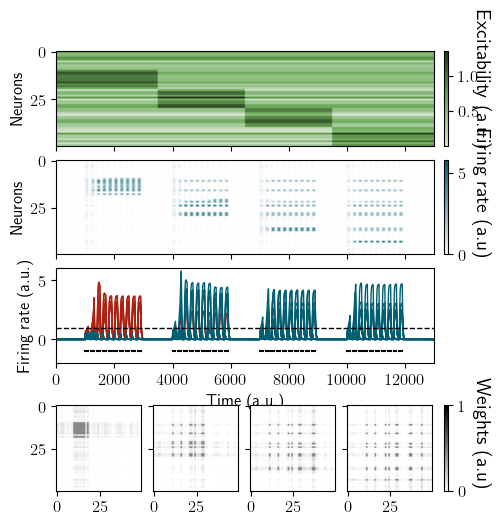

In [180]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(120*mm,120*mm), facecolor='w',frameon=False)

ax1 = fig.add_axes([.04,.79,.88,.2]) # [left, bottom, width, height] 
ax2 = fig.add_axes([.04,.56,.88,.2])
ax3 = fig.add_axes([.08,.33,.8,.2])

w = .18
ax5 = fig.add_axes([.08,.06,w,w])
ax6 = fig.add_axes([.285,.06,w,w])
ax7 = fig.add_axes([.49,.06,w,w])
ax8 = fig.add_axes([.695,.06,w,w])


im = ax1.imshow(Emat,aspect = nstep/N*2/8,cmap = cmap)
ax1.set_ylabel('Neurons')
ax1.set_xticklabels('')
cbar1 = plt.colorbar(im,cax = plt.axes([.9, 0.79, 0.01, 0.2])) # [left, bottom, width, height] 
cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=-.09,x=6)

im = ax2.imshow(np.maximum(0,r),aspect = nstep/N*2/8,cmap = cmap2)
ax2.set_ylabel('Neurons')
ax2.set_xticklabels('')
cbar2 = plt.colorbar(im,cax = plt.axes([.9, 0.56, 0.01, 0.2])) # [left, bottom, width, height] 
cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=-.09,x=6)

for n in active:
    ax3.plot(r[n,:],color[8],linewidth = 1)
for n in L:
    ax3.plot(r[n,:],color[1],linewidth = 1)


ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
ax3.set_xlabel('Time (a.u.)')
ax3.set_ylabel('Firing rate (a.u.)')

ax3.set_xlim([0,nstep])
ax3.set_ylim([-2,6])

h = -1
for s in range(int(len(seq)/2)):
    ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')


im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax6.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax7.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax8.imshow(y[index[1][:],12000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
ax6.set_yticklabels('')
ax7.set_yticklabels('')
ax8.set_yticklabels('')

cbar3 = plt.colorbar(im,cax = plt.axes([.9, 0.06, 0.01, 0.18]))
cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=-.02,x=6)
cbar3.set_ticks([0,1])
plt.savefig('all_slope.pdf')

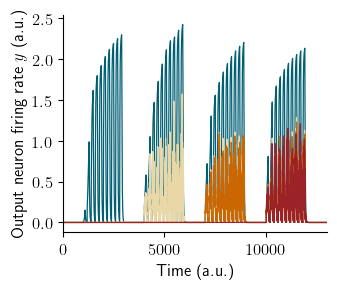

In [181]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(80*mm,70*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.16,0.18,.84,.79])

lw = .9
ax.plot(routbis[0,:],color[1],linewidth=lw);
ax.plot(routbis[1,:],color[4],linewidth=lw);
ax.plot(routbis[2,:],color[6],linewidth=lw);
ax.plot(routbis[3,:],color[9],linewidth=lw);

#plt.yscale('log')
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Output neuron firing rate $y$ (a.u.)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,13000])
plt.savefig('decode_rate.pdf')




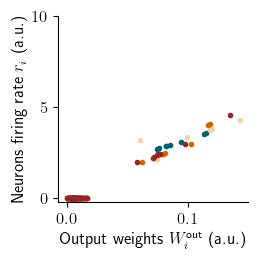

In [182]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(70*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


for t in [2900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[1])
for t in [5900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[4])
for t in [8900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[6])
for t in [11900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[9])

ax.set_xlabel(r'Output weights $W^{\text{out}}_i$ (a.u.)')
ax.set_ylabel(r'Neurons firing rate $r_i$ (a.u.)')
ax.set_yticks([0,5,10])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr.pdf')

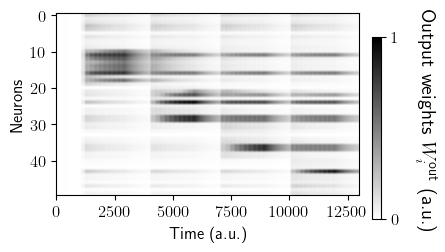

In [183]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(110*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.12,0.2,.7,.77])


ax.imshow(Wout, aspect='auto', cmap = 'binary')
cbar3 = plt.colorbar(im,cax = plt.axes([.85, 0.1, 0.02, 0.77]))
cbar3.ax.set_title(r'Output weights $W^{\text{out}}_i$ (a.u.)', rotation=270,loc='left',y=-.1,x=5)
cbar3.set_ticks([0,1])


ax.set_ylabel('Neurons')
ax.set_xlabel('Time (a.u.)')

plt.savefig('weights.pdf')

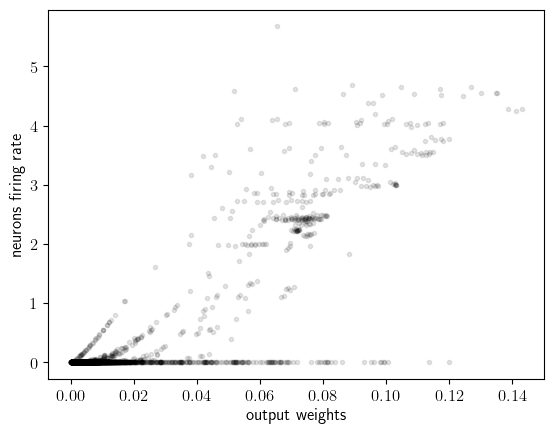

In [184]:
# weights vs rates
for t in np.arange(100,nstep,200):
    plt.plot(Wout[:,t],r[:,t],'k.', alpha = .1)
plt.xlabel('output weights')
plt.ylabel('neurons firing rate')
plt.savefig('decode_corr.png',dpi = 500)
plt.show()

In [185]:
W1 = Wout[:,2900]
W2 = Wout[:,5900]
W3 = Wout[:,8900]
W4 = Wout[:,11900]

In [186]:
pos = np.array(range(N))

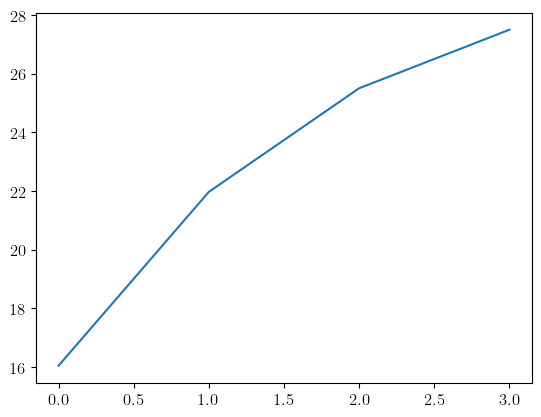

In [187]:
plt.plot([sum(np.multiply(W1,pos)),sum(np.multiply(W2,pos)),sum(np.multiply(W3,pos)),sum(np.multiply(W4,pos))])

In [188]:
slope

0.4

In [190]:
seedL = range(10)
WoutL = np.zeros((len(seedL),4))
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(slope,sigma,N)
    exc0 = np.sqrt(exc0*exc0)

    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    
    W1 = Wout[:,2900]
    W2 = Wout[:,5900]
    W3 = Wout[:,8900]
    W4 = Wout[:,11900]

    WoutL[seed,:] = np.array([sum(np.multiply(W1,pos))/np.sum(W1),sum(np.multiply(W2,pos))/np.sum(W2),sum(np.multiply(W3,pos))/np.sum(W3),sum(np.multiply(W4,pos))/np.sum(W4)])
    

(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 0)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 1)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 2)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 3)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 4)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 5)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 6)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 7)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 8)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 9)


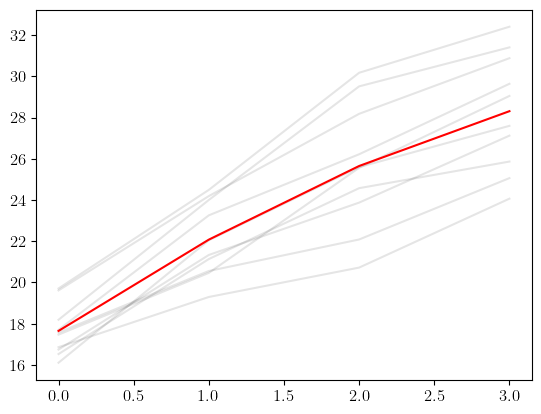

In [191]:
for i in range(10):
    plt.plot(WoutL[i,:],'k',alpha=.1)
plt.plot(np.mean(WoutL,axis=0),'r')

In [192]:
WoutLshuffled = np.copy(WoutL)
np.random.shuffle(WoutLshuffled.T)

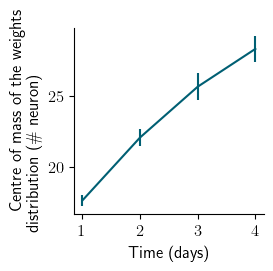

In [193]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(70*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


ax.errorbar([1,2,3,4],np.mean(WoutL,axis=0),stats.sem(WoutL),color = color[1])


ax.set_xlabel(r'Time (days)')
ax.set_ylabel(r'Centre of mass of the weights \newline distribution (\# neuron)')
#ax.set_yticks([0,5,10])
ax.set_xticks([1,2,3,4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr_slope.pdf')



### Run different seeds, fixed E, get V_list

In [194]:
Nseed = 10
V_list = np.zeros([4,N,Nseed])
for seed in range(Nseed):
    print(seed)
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(slope,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V
    
    #plot_all()
    #plt.show()

0
1
2
3
4
5
6
7
8
9


In [195]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])

corr_tot

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [ 0.06746367,  0.17472937,  0.31873797,  0.38055235,  0.08948359,
         0.49150792,  0.25193273,  0.13755251,  0.37780348,  0.57609788],
       [ 0.10253997,  0.20570162,  0.35394063,  0.3433582 , -0.03433817,
         0.26022343,  0.28423134, -0.04332757,  0.43404498,  0.61230739],
       [ 0.09474565,  0.26243002,  0.34320677,  0.4221597 , -0.01656475,
         0.24914823,  0.23250227,  0.0349246 ,  0.41261402,  0.57240504]])

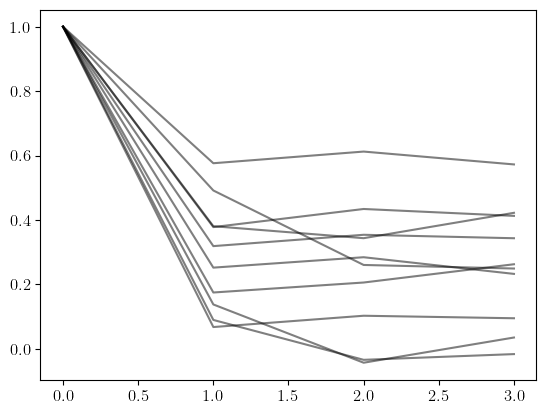

In [196]:
for seed in range(Nseed):
    plt.plot(corr_tot[:,seed],'k', alpha = .5)

### figure

In [197]:
Nseed = 10

In [198]:
V_list_shuffled = np.copy(V_list)

In [199]:
for seed in range(Nseed):
    for day in range(4):
        np.random.shuffle(V_list_shuffled[day,:,seed])

In [200]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])
        
corr_tot_shuffled = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot_shuffled[day,seed] = correlation(V_list_shuffled[0,:,seed],V_list_shuffled[day,:,seed])

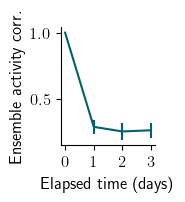

In [202]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(30*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

ax.errorbar([0,1,2,3], np.mean(corr_tot,axis=1),stats.sem(corr_tot,axis = 1), color = color[1])
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr_slope.pdf',bbox_inches='tight')

### Ordinal time decoder, run different E, get t_mat

In [203]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))

In [204]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [205]:
seedL = np.arange(0,10,1)
seedL

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [207]:
EL = np.arange(0,.8,.1)
EL = np.arange(0,1.6,.2)
Nseed = len(seedL)
#EL = [1.5]
EL

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4])

In [ ]:
t_mat = []
t_mat_shuffled = []
V_list = np.zeros([4,N,Nseed])
V_list_suffled = np.zeros([4,N])
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(slope,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]

    
    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V

    np.save("V_list.npy", V_list)

    # decoder ordinal
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            #print(V[perm[i],:])
            s += correlation(V[perm[i],:],V[perm[i+1],:])
        s = s
        s_corr.append(s)
    #print(s_corr)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    # shuffle
    
    #V_list_suffled = np.copy(V_list[:,:,seed])
    #np.random.shuffle(V_list_suffled.T)
    for i in range(N):
        line = np.copy(V[:,i])
        np.random.shuffle(line)
        V_list_suffled[:,i] = line
    
    #print(V_list[:,:,seed] == V_list_suffled)

    #print(V_list)
    #print(V_list_suffled)
    
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list_suffled[perm[i],:],V_list_suffled[perm[i+1],:])
        s = s
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_shuffled.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    #plot_all()
    #plt.savefig(str(E)+'all.pdf')
    #plt.show()




In [4644]:
#np.save("t_mat_slope.npy", t_mat)
#np.save("t_mat_shuffled_slope.npy", t_mat_shuffled)

In [209]:
t_mat = np.array(t_mat).reshape((len(EL),len(decayL),len(seedL)))
t_mat_shuffled = np.array(t_mat_shuffled).reshape((len(EL),len(decayL),len(seedL)))

decay = 0
#t_mat = np.abs(t_mat[:,decay,:])
#t_mat_shuffled = np.abs(t_mat_shuffled[:,decay,:])
t_mat = t_mat[:,decay,:]
t_mat_shuffled = t_mat_shuffled[:,decay,:]

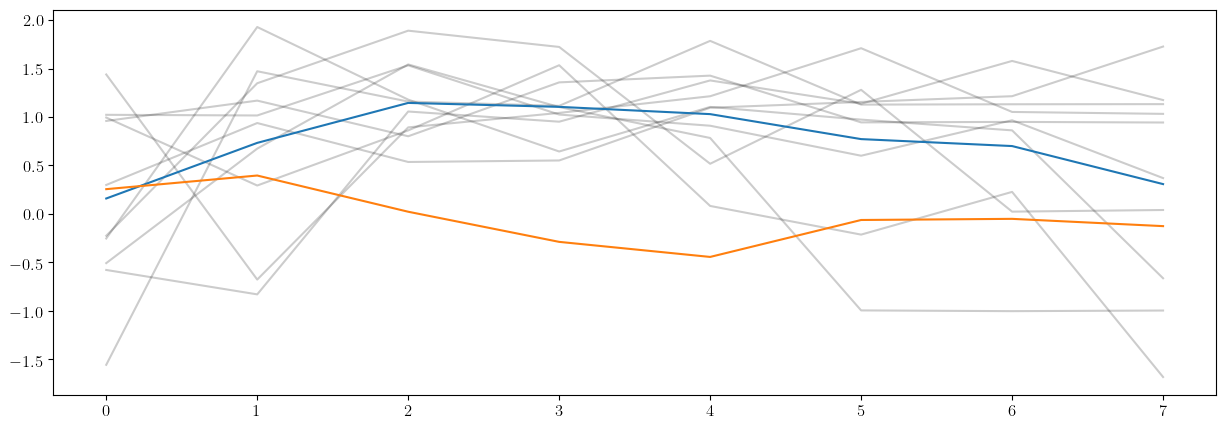

In [210]:
Nseed = len(seedL)
plt.figure(figsize = (15,5))
for seed in range(Nseed):
    plt.plot(t_mat[:,seed],'k', alpha = .2)
plt.plot(np.mean(t_mat,axis = 1))
plt.plot(np.mean(t_mat_shuffled,axis = 1))
#plt.xticks(range(len(EL)),lab);

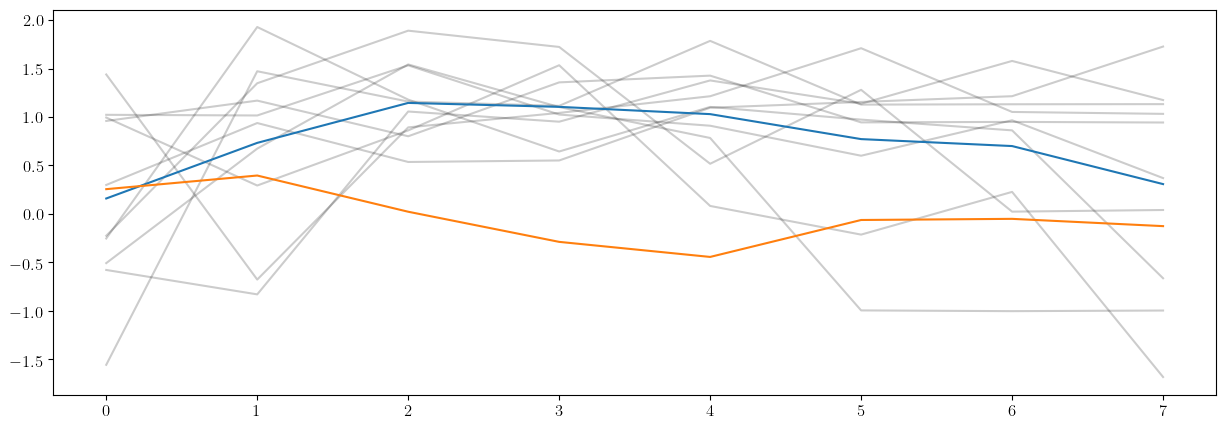

In [211]:
Nseed = len(seedL)
plt.figure(figsize = (15,5))
for seed in range(Nseed):
    plt.plot(t_mat[:,seed],'k', alpha = .2)
plt.plot(np.mean(t_mat,axis = 1))
plt.plot(np.mean(t_mat_shuffled,axis = 1))
#plt.xticks(range(len(EL)),lab);

### figure

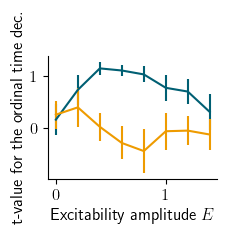

In [212]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat,axis = 1),stats.sem(t_mat,axis = 1),color = color[1])
ax.errorbar(EL,np.mean(t_mat_shuffled,axis = 1),stats.sem(t_mat_shuffled,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('tVSE_slope.pdf',bbox_inches='tight')



### figure


In [217]:
threshold = 1
tauwL = [700]
taurL = [20]
tauthetaL = [100]
I0L = [4]
I1L = [.7]
EL = [.5]
y0L = [2]
sigmaL = [.2]
decayL = [800]
INL = [15]
seedL = [0]
slopeL = [.4]
capL = [.5]
I2L = [.05]
(700, 20, 100, 4, 0.7, 1, 2, 0.2, 800, 15, 1, 0.5, 0.6, 0.05)## works ok but not good decay

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,slope,cap,I2)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0],slopeL[0],capL[0],I2L[0])
# slope = .2

In [218]:
pos = np.array(range(N))
pos

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [219]:
seedL = range(10)
WoutL = np.zeros((len(seedL),4))
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(slope,sigma,N)
    #exc0 = np.random.uniform(slope-sigma,slope+sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)

    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    
    W1 = Wout[:,2900]
    W2 = Wout[:,5900]
    W3 = Wout[:,8900]
    W4 = Wout[:,11900]

    WoutL[seed,:] = np.array([sum(np.multiply(W1,pos))/np.sum(W1),sum(np.multiply(W2,pos))/np.sum(W2),sum(np.multiply(W3,pos))/np.sum(W3),sum(np.multiply(W4,pos))/np.sum(W4)])
    

(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 0)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 1)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 2)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 3)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 4)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 5)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 6)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 7)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 8)
(700, 20, 100, 4, 0.7, 0.5, 2, 0.2, 800, 15, 9)


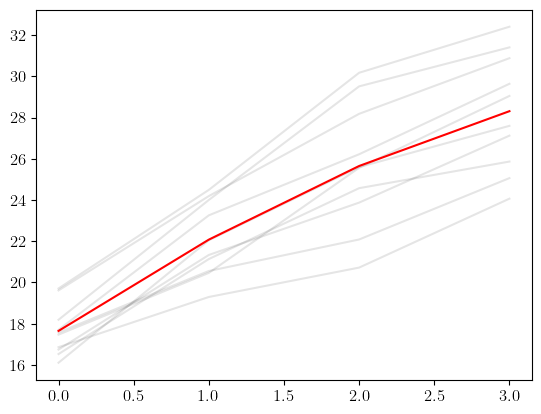

In [220]:
for i in range(10):
    plt.plot(WoutL[i,:],'k',alpha=.1)
plt.plot(np.mean(WoutL,axis=0),'r')

In [221]:
WoutLshuffled = np.copy(WoutL)
np.random.shuffle(WoutLshuffled.T)


In [222]:
WoutL

array([[16.10402668, 22.04834347, 25.59929358, 27.60117338],
       [19.61382665, 24.19261282, 28.18508856, 30.88592138],
       [17.70238261, 23.25803463, 26.22250713, 29.64310894],
       [16.52455726, 21.13621272, 24.57636215, 25.86805198],
       [18.189042  , 24.0044804 , 29.51788056, 31.41006618],
       [17.46681546, 20.46497425, 25.56549665, 29.05307348],
       [16.74324179, 21.33453609, 23.87538434, 27.12589459],
       [19.70829793, 24.49341853, 30.17791682, 32.4126992 ],
       [16.85869683, 19.29460907, 20.72113415, 24.06696404],
       [17.57259639, 20.5556209 , 22.08564739, 25.06498778]])

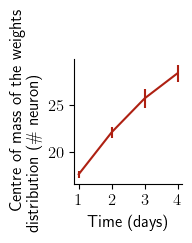

In [223]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(40*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


ax.errorbar([1,2,3,4],np.mean(WoutL,axis=0),stats.sem(WoutL),color = "#ae2012")


ax.set_xlabel(r'Time (days)')
ax.set_ylabel(r'Centre of mass of the weights \newline distribution (\# neuron)')
#ax.set_yticks([0,5,10])
ax.set_xticks([1,2,3,4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr_slope.pdf',bbox_inches='tight')



## Revision: drift rate vs size engram

reload original model

In [240]:
threshold = 3

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [241]:
Nseed = 100
V_list = np.zeros([4,N,Nseed])
for seed in range(Nseed):
    print(seed)
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V
        
    #plot_all()
    #plt.show()
    
np.save("V_list.npy", V_list)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [242]:
#V_list = np.load('V_list.npy')

In [243]:
np.shape(V_list)

(4, 50, 100)

In [244]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])
        

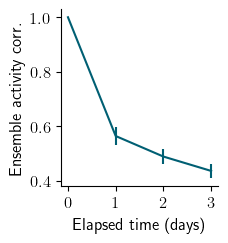

In [245]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

ax.errorbar([0,1,2,3], np.mean(corr_tot,axis=1),stats.sem(corr_tot,axis = 1), color = color[1])
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr.pdf')

In [246]:
corrL = np.zeros((Nseed,4))
size = np.zeros((Nseed,4))

for seed in range(Nseed):
    V0 = V_list[0,:,seed]
    V1 = V_list[1,:,seed]
    V2 = V_list[2,:,seed]
    V3 = V_list[3,:,seed]
    
    corrL[seed,:] = [correlation(V0,V0),correlation(V0,V1),correlation(V0,V2),correlation(V0,V3)]
    size[seed,:] = [np.sum(V0>threshold),np.sum(V1>threshold),np.sum(V2>threshold),np.sum(V3>threshold)]
drift = np.sum(1-corrL[:,:],1)

In [247]:
drift

array([1.33174369, 1.14178409, 1.39064433, 1.46599429, 1.05740459,
       0.51624027, 1.37616287, 0.80281624, 0.86175054, 0.85325589,
       3.39449083, 0.69948506, 2.11329595, 2.66090318, 2.63355717,
       3.39075196, 1.04081354, 0.23139093, 0.80259105, 2.76253422,
       1.23352987, 2.77075912, 0.97945461, 0.4142032 , 2.79973188,
       2.23455122, 0.96202296, 1.02979583, 0.77322473, 1.76876756,
       0.82105544, 2.6932898 , 0.48196361, 2.63213571, 1.24502279,
       1.44899749, 1.29069145, 2.59499648, 0.90772163, 2.06930781,
       2.79054827, 3.39085012, 1.5145277 , 2.04841608, 0.97494876,
       1.13792317, 1.09632118, 3.33108095, 0.30575405, 2.7784337 ,
       0.62229026, 2.67064235, 2.77480203, 0.91105058, 2.63654976,
       0.55039421, 1.75404351, 1.45916299, 2.64889892, 1.51190425,
       1.35610252, 1.951531  , 1.28385042, 1.37573246, 1.31235755,
       1.19794272, 0.72103991, 0.66990264, 1.31069431, 1.90000452,
       0.62715574, 0.92588046, 0.30254986, 0.63858669, 1.20326

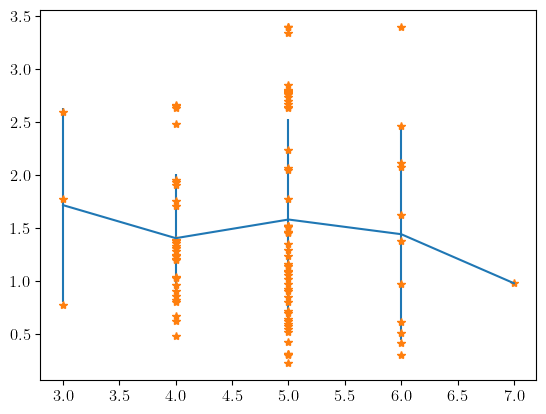

In [248]:
X = range(3,8)
Y = []
errY = []
for s in X:
    l = np.where(size[:,0] == s)[0]
    l_drift = np.zeros(len(l))
    for i in range(len(l)):
        l_drift[i] = drift[l[i]]
    Y.append(np.mean(l_drift))
    try:
        errY.append(statistics.stdev(l_drift))
    except:
        errY.append(0)

plt.errorbar(X,Y,errY)
plt.plot(size[:,0],drift,'*')

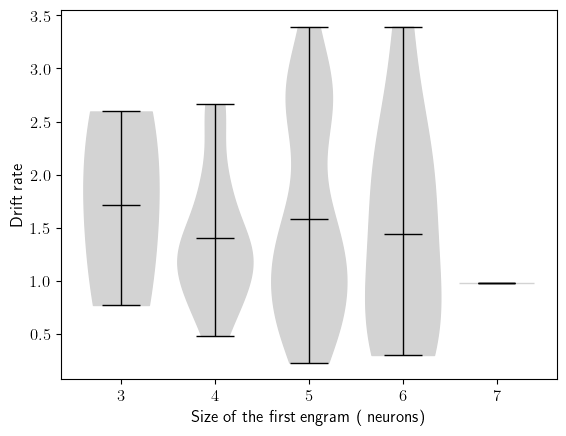

In [249]:
import matplotlib.pyplot as plt
import numpy as np


for s in range(3,8):
    l = np.where(size[:,0] == s)[0]
    l_drift = np.zeros(len(l))
    for i in range(len(l)):
        l_drift[i] = drift[l[i]]
        
    positions = [s]
    parts = plt.violinplot(dataset=l_drift,positions=positions,widths = .8,showmeans=True, showmedians=False);
    for pc in parts['bodies']:
        pc.set_facecolor('lightgray')
        pc.set_edgecolor('lightgray')
        pc.set_alpha(1)

    for partname in ('cbars','cmins','cmaxes','cmeans'):
        vp = parts[partname]
        vp.set_edgecolor('k')
        vp.set_linewidth(1)

plt.xlabel('Size of the first engram ( neurons)')
plt.ylabel('Drift rate');
plt.savefig('driftVSsize.pdf')


In [250]:
threshold = 3

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [12]
I1L = [.5]
EL = np.arange(0,3.1,.1)
EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [15]
seedL = range(10)

(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [251]:
Nseed = 10
EL = [0,.5,1,1.5,2,2.5,3]
V_list = np.zeros([4,N,Nseed,len(EL)])
for e in range(len(EL)):
    E = EL[e]
    for seed in range(Nseed):
        print(seed)

         # initialisation
        np.random.seed(seed)
        r0 = np.zeros(N)
        W0 = np.zeros(N*N)
        exc0 = np.zeros(N)
        exc0 = np.random.normal(0,sigma,N)
        exc0 = np.sqrt(exc0*exc0)
        #exc0 = np.random.uniform(0,sigma,N)
        theta0 = np.zeros(N)

        Emat = def_Emat(E,exc0)

        # run
        y = run(INPUT)
        exc = y[index[2][:],:]
        r = y[index[0][:],:]
        theta = y[index[3][:],:]


        V0 = r[:,2900]
        V1 = r[:,5900]
        V2 = r[:,8900]
        V3 = r[:,11900]
        V = np.array([V0,V1,V2,V3])
        V_list[:,:,seed,e] = V

        #plot_all()
        #plt.show()
np.save("V_list_E.npy", V_list)


0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9


In [252]:
V_list = np.load('V_list_E.npy')

In [253]:
corr_tot = np.zeros((4,Nseed,len(EL)))
for e in range(len(EL)):
    for day in range(4):
        for seed in range(Nseed):
            corr_tot[day,seed,e] = correlation(V_list[0,:,seed,e],V_list[day,:,seed,e])
        

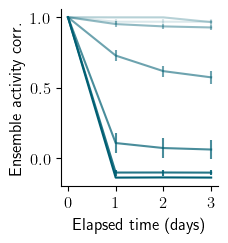

In [254]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

for e in range(len(EL)):
    ax.errorbar([0,1,2,3], np.mean(corr_tot[:,:,e],axis=1),stats.sem(corr_tot[:,:,e],axis = 1), color = color[1],alpha = (e+1)/len(EL))

    ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr.pdf')

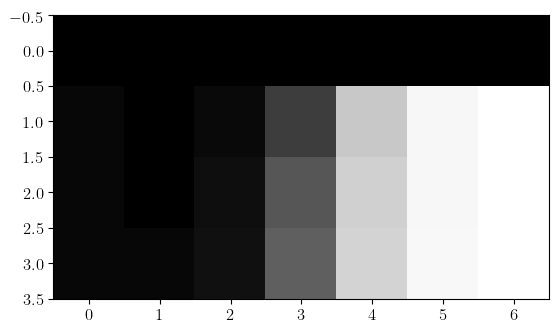

In [255]:
plt.imshow(np.mean(corr_tot[:,:,:],axis=1),cmap = 'binary')

In [183]:
size = np.zeros((4,Nseed,len(EL)))

for e in range(len(EL)):
    for day in range(4):
        for seed in range(Nseed):
            size[day,seed,e] = np.sum(V_list[day,:,seed,e] > threshold)


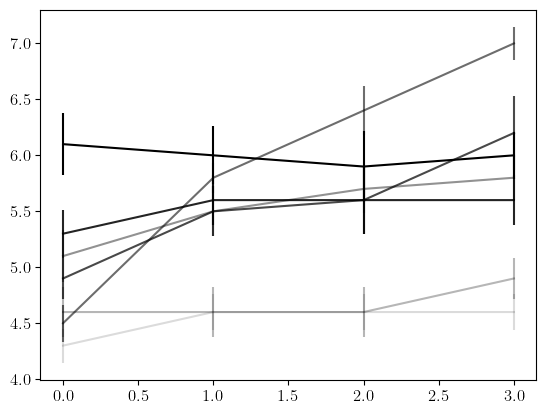

In [182]:
for e in range(len(EL)):
    plt.errorbar([0,1,2,3],np.mean(size[:,:,e],axis = 1),stats.sem(size[:,:,e],axis = 1),color='k',alpha = (e+1)/len(EL))


In [189]:
drift = np.max(1-corr_tot[:,:,:],0)

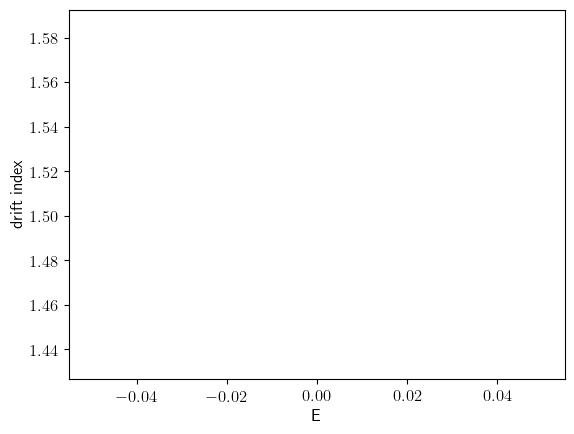

In [33]:
plt.plot(np.mean(drift,axis=0))
plt.xlabel('E')
plt.ylabel('drift index')
plt.savefig('driftVSE.png')

In [202]:
size

array([[[5., 5., 5., 4., 4., 5., 5.],
        [4., 4., 6., 5., 5., 5., 6.],
        [5., 4., 5., 4., 4., 5., 7.],
        [4., 5., 5., 5., 6., 7., 7.],
        [4., 4., 5., 5., 5., 5., 6.],
        [5., 4., 6., 5., 5., 5., 7.],
        [4., 4., 4., 4., 5., 5., 5.],
        [4., 6., 5., 4., 5., 5., 5.],
        [4., 5., 4., 4., 5., 6., 6.],
        [4., 5., 6., 5., 5., 5., 7.]],

       [[5., 5., 5., 5., 5., 5., 6.],
        [5., 4., 6., 6., 6., 6., 7.],
        [5., 4., 5., 5., 5., 5., 5.],
        [5., 5., 5., 6., 5., 6., 6.],
        [4., 4., 5., 6., 6., 7., 7.],
        [5., 4., 6., 6., 7., 6., 7.],
        [4., 4., 5., 6., 5., 6., 6.],
        [4., 6., 6., 6., 5., 5., 5.],
        [4., 5., 5., 6., 5., 5., 6.],
        [5., 5., 7., 6., 6., 5., 5.]],

       [[5., 5., 6., 6., 7., 6., 4.],
        [5., 4., 6., 7., 6., 7., 7.],
        [5., 4., 5., 5., 5., 4., 5.],
        [5., 5., 6., 6., 5., 6., 7.],
        [4., 4., 5., 7., 4., 6., 6.],
        [5., 4., 6., 7., 5., 4., 5.],
        

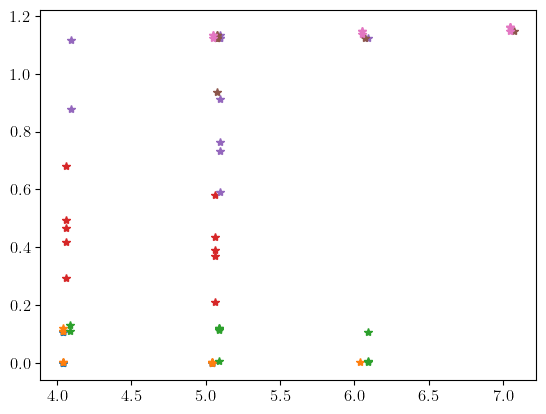

In [201]:
for e in range(len(EL)):
    plt.plot(size[0,:,e]+random.random()*.1,drift[:,e],'*')

In [203]:
size[0,:,e]

array([5., 6., 7., 7., 6., 7., 5., 5., 6., 7.])

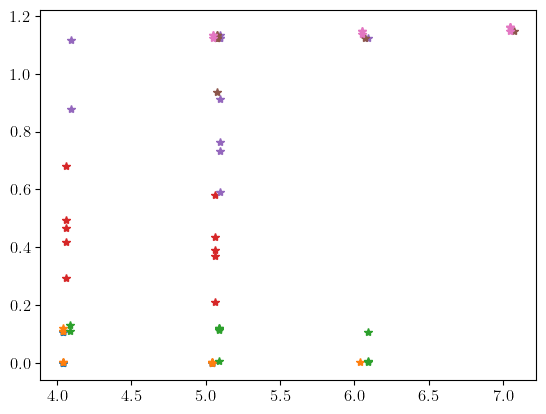

In [201]:
for e in range(len(EL)):
    plt.plot(size[0,:,e],drift[:,e],'*')

In [219]:
size[0,:,e]

array([4., 5., 4., 5., 5., 5., 4., 4., 4., 5.])

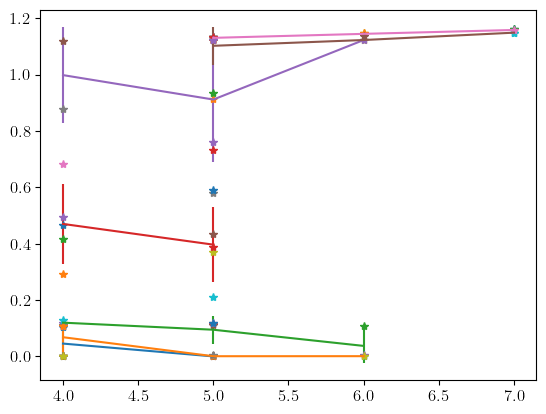

In [227]:
X = range(3,8)
for e in range(len(EL)):
#for e in [6]:
    Y = []
    errY = []
    for s in X:
        l = np.where(size[0,:,e] == s)[0]
        l_drift = np.zeros(len(l))
        for i in range(len(l)):
            l_drift[i] = drift[l[i],e]
        try:
            Y.append(np.mean(l_drift))
        except:
            Y.append([])
        try:
            errY.append(statistics.stdev(l_drift))
        except:
            errY.append(0)

    plt.errorbar(X,Y,errY)
    for s in range(Nseed):
        plt.plot(size[0,s,e],drift[s,e],'*')
#plt.plot(size[:,0],drift,'*')

In [139]:
l_drift

array([1.33174369, 1.39064433, 1.37616287, 0.80281624, 0.86175054,
       2.66090318, 2.63355717, 1.04081354, 1.23352987, 0.96202296,
       1.02979583, 0.82105544, 0.48196361, 1.24502279, 0.62229026,
       0.91105058, 1.75404351, 2.64889892, 1.35610252, 1.951531  ,
       1.28385042, 1.31235755, 1.19794272, 0.66990264, 1.31069431,
       1.90000452, 1.20326764, 1.93658737, 2.4787109 , 1.70924101])

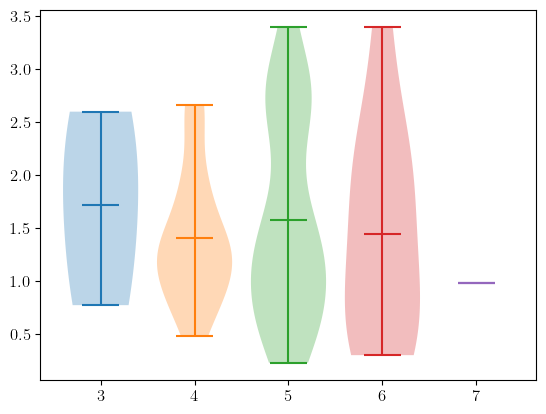

In [165]:
for s in range(3,8):
    l = np.where(size[:,0] == s)[0]
    l_drift = np.zeros(len(l))
    for i in range(len(l)):
        l_drift[i] = drift[l[i]]
        
    plt.violinplot(dataset=l_drift,positions=[s],widths = .8,showmeans=True, showextrema=True, showmedians=False);

## Revision sparsity
increased IN

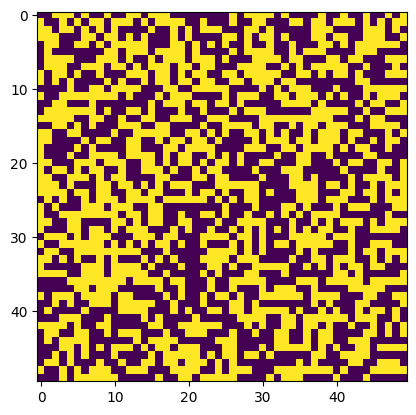

In [7]:
np.random.seed(4)
mask = np.random.randint(2, size=(N, N))
plt.imshow(mask)

In [8]:
mask

array([[0, 0, 1, ..., 1, 0, 1],
       [1, 0, 0, ..., 0, 1, 1],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [0, 1, 1, ..., 1, 1, 0],
       [1, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [9]:
def run(INPUT):
    global theta
    theta = 0
    global step
    step = 0
    thetaL=np.zeros((N,1))
    y0 = np.concatenate((r0,W0,exc0,theta0,Wout0,rout0,thetaout0))
    y = np.zeros((len(y0),nstep))
    routbis = np.zeros((4,nstep))

    y[:,0] = y0
    
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,tag,dt)[np.newaxis]);
    return y


In [10]:
# main function
routbis = np.zeros((4,nstep))
S = []
def f(yt,t,tag,dt):
    
    global theta
    global routbis
    global routbis_shuffled
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    Wout = yt[index[4]].reshape((1,N))
    #rout = yt[index[5]][np.newaxis].T
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T
    thetaout = yt[index[6]][np.newaxis].T


    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=cap,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    # sparsity
    dWdt = np.multiply(dWdt,mask)
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
    
    
    rout = Wout.dot(r)[0]
    routbis[0,t] = rout
    dWoutdt = (1 - np.sum(Wout))*r.T * rout/200 - Wout/1000
    #dWoutdt = r.T * rout/1000 - Wout/1000
    #dWoutdt = (rout * (rout-thetaout) * r.T )/ 4000
    #dWoutdt = np.multiply(dWoutdt,Wout<10)
    dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout<=0,dWoutdt<0)))
    #dWoutdt = np.multiply(dWoutdt,np.logical_not(np.logical_and(Wout>=10,dWoutdt>0)))
    #droutdt = (Wout.dot(r) - rout) /1
    #dthetaoutdt = ((rout*rout)/.2 - thetaout)/10
    dthetaoutdt = np.zeros((1))
    droutdt = np.zeros((1))
    S.append(np.sum(Wout))
    
    if t > 3000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[1,t] = Wout.dot(r)[0]

    if t > 6000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[2,t] = Wout.dot(r)[0]
        
    if t > 9000:
        Wout = Wout.T
        np.random.shuffle(Wout)
        Wout = Wout.T
        routbis[3,t] = Wout.dot(r)[0]
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten(),
                           dWoutdt.flatten(),
                           droutdt.flatten(),
                           dthetaoutdt.flatten()))

    return dydt

In [16]:
N = 50
I0 = 5
I1 = 1
E = 5
#taus = 2000

taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)
rout0 = np.zeros(1)
Wout0 = np.zeros(N) + .001
thetaout0 = np.zeros(1)
tag = 0
nstep = 13000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000

seq = []
Nevent = 4
for ev in range(Nevent):

    for i in range(Nstim):
        seq.append(pause + i*stim + delay*ev)
        seq.append(pause + i*stim + duration + delay*ev)
    
def INPUT(t):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * np.ones(N)*L/2 + 1


index = [range(0,N),
         range(N,N + N*N),
         range(N + N*N,N + N*N +N),
         range(N + N*N +N,N + N*N+N+N),
         range(N + N*N +N+N,N + N*N +N+N+N),
         range(N + N*N +N+N+N,N + N*N +N+N+N+1),
         range(N + N*N +N+N+N+1,N + N*N +N+N+N+1+1)]
         
         
         
         
         

In [17]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:3500] = E
    Emat[20:30,3500:6500] = E
    Emat[30:40,6500:9500] = E
    Emat[40:50,9500:] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


In [18]:
threshold = 5

decayL = [1000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [7]
I1L = [.8]
#EL = np.arange(0,3.1,.1)
#EL = [0,1.5,3]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [20]
seedL = [6]
capL = [1]
(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])
(800, 20, 100, 10, 0.5, 1.5, 2, 1, 1000, 18, 7)

(800, 20, 100, 10, 0.5, 1.5, 2, 1, 1000, 18, 7)

In [19]:
exc0 = np.zeros(N)
exc0 = np.random.normal(0,sigma,N)
exc0 = np.sqrt(exc0*exc0)

exc0

array([0.42043777, 0.16314095, 0.72340346, 0.25757669, 0.29305842,
       0.08453544, 0.73105667, 1.10697333, 0.46371764, 1.20919434,
       0.42991303, 0.70288517, 0.47564991, 1.31035404, 0.5557295 ,
       0.49314699, 0.75731987, 0.92162088, 0.78888138, 1.15470569,
       1.256633  , 1.94394558, 0.67906591, 0.63399479, 0.90531306,
       1.7057592 , 1.12554042, 0.15786502, 0.80482898, 1.96946592,
       0.89460145, 1.09783182, 0.13229553, 0.94756108, 0.95521542,
       0.44853641, 1.16307006, 0.500814  , 1.87024672, 0.02218831,
       0.65357872, 1.52215039, 0.88786231, 1.29994329, 0.65021833,
       2.04325393, 1.1313358 , 1.1078353 , 0.6933076 , 0.40987581])

In [20]:
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,cap) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL,capL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed,cap))
    
    
     # initialisation
    np.random.seed(seed)
    random.seed(seed)
    mask = np.random.randint(2, size=(N, N))

    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    rout = y[index[5][:],:] 
    
    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    
    # decoder ordinal
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            #print(V[perm[i],:])
            s += correlation(V[perm[i],:],V[perm[i+1],:])
        s = s
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
 
    for i in range(N):
        line = np.copy(V[:,i])
        np.random.shuffle(line)
        V_list_suffled[:,i] = line
 
    
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list_suffled[perm[i],:],V_list_suffled[perm[i+1],:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    
    
    plot_all()
    #plt.savefig('all.pdf')

    plt.show()
  

    plt.plot([correlation(V0,V0),correlation(V0,V1),correlation(V0,V2),correlation(V0,V3)])
    plt.show()




(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 6, 1)


NameError: name 'L' is not defined

### figure

In [ ]:
threshold = 5

In [ ]:
active = r[:,2850]>threshold

In [ ]:
active = np.where(active)[0]

In [ ]:
L = np.array(range(N))
for l in active:
    L = np.delete(L,l)

In [ ]:
L = [i for i in range(N) if i not in active]

In [ ]:
active

In [ ]:
cmap = reversed(["20331a","33512a","446c37","558745","66a253","7cb36b","94c186","abcea1","c3dcbc","dbead7"])
cmap2 = ["ffffff","005F73"]

In [ ]:
import matplotlib.colors as mcolors
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

cmap = get_continuous_cmap(cmap)
cmap2 = get_continuous_cmap(cmap2)

In [ ]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(160*mm,160*mm), facecolor='w',frameon=False)

ax1 = fig.add_axes([.04,.79,.88,.2]) # [left, bottom, width, height] 
ax2 = fig.add_axes([.04,.56,.88,.2])
ax3 = fig.add_axes([.08,.33,.8,.2])

w = .18
ax5 = fig.add_axes([.08,.06,w,w])
ax6 = fig.add_axes([.285,.06,w,w])
ax7 = fig.add_axes([.49,.06,w,w])
ax8 = fig.add_axes([.695,.06,w,w])


im = ax1.imshow(Emat,aspect = nstep/N*2/8,cmap = cmap)
ax1.set_ylabel('Neurons')
ax1.set_xticklabels('')
cbar1 = plt.colorbar(im,cax = plt.axes([.9, 0.79, 0.01, 0.2])) # [left, bottom, width, height] 
cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=-.09,x=6)

im = ax2.imshow(np.maximum(0,r),aspect = nstep/N*2/8,cmap = cmap2)
ax2.set_ylabel('Neurons')
ax2.set_xticklabels('')
cbar2 = plt.colorbar(im,cax = plt.axes([.9, 0.56, 0.01, 0.2])) # [left, bottom, width, height] 
cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=-.09,x=6)

for n in active:
    ax3.plot(r[n,:],color[8],linewidth = 1)
for n in L:
    ax3.plot(r[n,:],color[1],linewidth = 1)


ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
ax3.set_xlabel('Time (a.u.)')
ax3.set_ylabel('Firing rate (a.u.)')

ax3.set_xlim([0,nstep])
ax3.set_ylim([-2,15])

h = -1
for s in range(int(len(seq)/2)):
    ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')


im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax6.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax7.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
im = ax8.imshow(y[index[1][:],12000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
ax6.set_yticklabels('')
ax7.set_yticklabels('')
ax8.set_yticklabels('')

cbar3 = plt.colorbar(im,cax = plt.axes([.9, 0.06, 0.01, 0.18]))
cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=-.02,x=6)
cbar3.set_ticks([0,1])
plt.savefig('all_sparsity.pdf')

In [22]:
Nseed = 10
V_list = np.zeros([4,N,Nseed])
for seed in range(Nseed):
    print(seed)
    
     # initialisation
    np.random.seed(seed)
    
    mask = np.random.randint(2, size=(N, N))


    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)


    # run
    y = run(INPUT)
    r = y[index[0][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]

    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V
        
    
np.save("V_list_sparsity.npy", V_list)

0
1
2
3
4
5
6
7
8
9


In [23]:
#np.save("V_list.npy", V_list)
V_list = np.load('V_list_sparsity.npy')

In [24]:
corr_tot = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corr_tot[day,seed] = correlation(V_list[0,:,seed],V_list[day,:,seed])
        

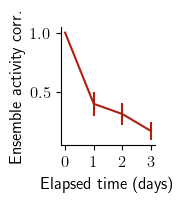

In [25]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(30*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

ax.errorbar([0,1,2,3], np.mean(corr_tot,axis=1),stats.sem(corr_tot,axis = 1), color = color[8])
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr_sparsity.pdf',bbox_inches='tight')

### figure

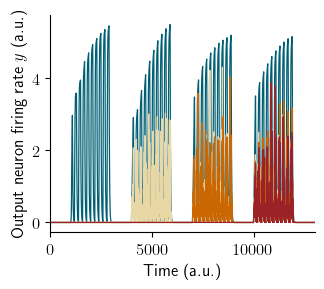

In [26]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(80*mm,70*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.16,0.18,.84,.79])

lw = .9
ax.plot(routbis[0,:],color[1],linewidth=lw);
ax.plot(routbis[1,:],color[4],linewidth=lw);
ax.plot(routbis[2,:],color[6],linewidth=lw);
ax.plot(routbis[3,:],color[9],linewidth=lw);

#plt.yscale('log')
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Output neuron firing rate $y$ (a.u.)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,13000])
plt.savefig('decode_rate.pdf')




### figure

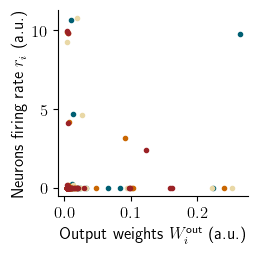

In [27]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(70*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


for t in [2900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[1])
for t in [5900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[4])
for t in [8900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[6])
for t in [11900]:
    ax.plot(Wout[:,t],r[:,t],'.',color = color[9])

ax.set_xlabel(r'Output weights $W^{\text{out}}_i$ (a.u.)')
ax.set_ylabel(r'Neurons firing rate $r_i$ (a.u.)')
ax.set_yticks([0,5,10])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr.pdf')

### figure

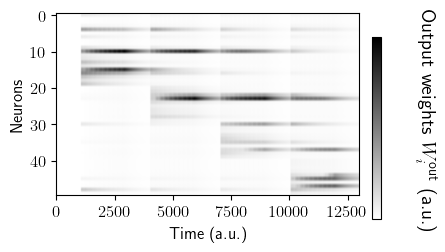

In [29]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(110*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.12,0.2,.7,.77])


im = ax.imshow(Wout, aspect='auto', cmap = 'binary')
cbar3 = plt.colorbar(im,cax = plt.axes([.85, 0.1, 0.02, 0.77]))
cbar3.ax.set_title(r'Output weights $W^{\text{out}}_i$ (a.u.)', rotation=270,loc='left',y=-.1,x=5)
cbar3.set_ticks([0,1])


ax.set_ylabel('Neurons')
ax.set_xlabel('Time (a.u.)')

plt.savefig('weights.pdf')

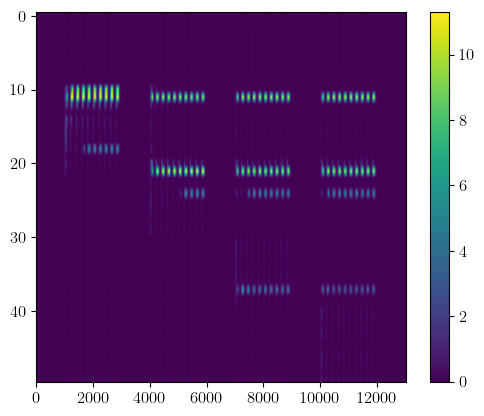

In [30]:
plt.figure()
plt.imshow(r,aspect = nstep/N)
plt.colorbar()

In [31]:
r[:,2900]

array([1.70314747e-03, 2.63614862e-03, 2.00497856e-03, 2.46235537e-03,
       2.27986730e-03, 2.49185620e-03, 2.36280477e-03, 2.34126418e-03,
       1.68093538e-03, 1.92276408e-03, 9.76256226e+00, 1.06316296e+01,
       2.72519600e-01, 2.78834224e-03, 1.05642166e-02, 1.19258513e-02,
       5.22900556e-03, 5.73826535e-03, 4.70522957e+00, 2.84469339e-03,
       4.99470304e-03, 3.10002631e-03, 2.04471499e-03, 1.72416727e-03,
       2.17057670e-03, 2.17678508e-03, 2.12896660e-03, 1.98927052e-03,
       1.77360729e-03, 2.25939805e-03, 1.89222344e-03, 2.12607434e-03,
       1.94164388e-03, 2.07969083e-03, 2.00871694e-03, 2.04609782e-03,
       2.08755495e-03, 2.44341846e-03, 1.96305259e-03, 1.79706870e-03,
       2.67124020e-03, 2.14247804e-03, 1.92735356e-03, 2.55567678e-03,
       1.97654543e-03, 1.85915831e-03, 2.35167979e-03, 2.20903954e-03,
       1.77493911e-03, 2.36730897e-03])

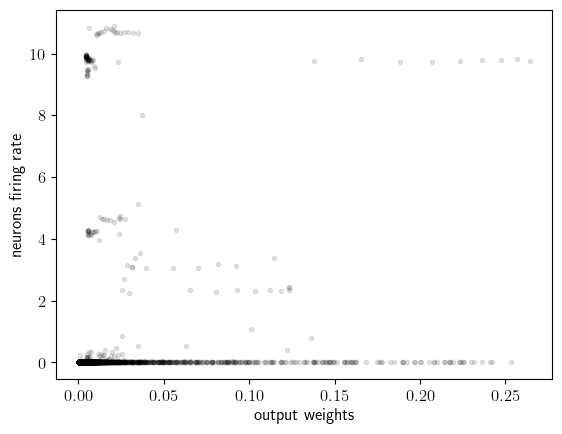

In [32]:
# weights vs rates
for t in np.arange(100,nstep,200):
    plt.plot(Wout[:,t],r[:,t],'k.', alpha = .1)
plt.xlabel('output weights')
plt.ylabel('neurons firing rate')
plt.savefig('decode_corr.png',dpi = 500)
plt.show()

### figure


In [33]:
pos = np.array(range(N))
pos

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [34]:
seedL = range(10)
WoutL = np.zeros((len(seedL),4))
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    
    mask = np.random.randint(2, size=(N, N))

    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    
    W1 = Wout[:,2900]
    W2 = Wout[:,5900]
    W3 = Wout[:,8900]
    W4 = Wout[:,11900]

    WoutL[seed,:] = np.array([sum(np.multiply(W1,pos))/np.sum(W1),sum(np.multiply(W2,pos))/np.sum(W2),sum(np.multiply(W3,pos))/np.sum(W3),sum(np.multiply(W4,pos))/np.sum(W4)])
    

(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 0)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 1)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 2)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 3)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 4)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 5)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 6)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 7)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 8)
(800, 20, 100, 7, 0.8, 1.5, 2, 1, 1000, 20, 9)


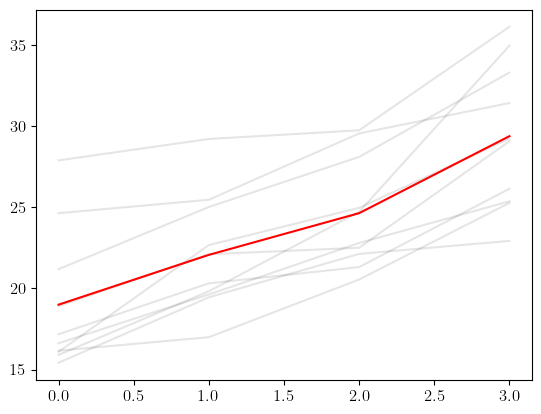

In [35]:
for i in range(10):
    plt.plot(WoutL[i,:],'k',alpha=.1)
plt.plot(np.mean(WoutL,axis=0),'r')

In [36]:
WoutLshuffled = np.copy(WoutL)
np.random.shuffle(WoutLshuffled.T)


In [37]:
WoutL

array([[16.08698119, 22.66314328, 24.95878196, 29.21754106],
       [18.90034737, 22.10017664, 22.4992067 , 29.06266262],
       [21.17791191, 25.0095637 , 28.09303342, 33.28951142],
       [27.87929365, 29.19922789, 29.73247072, 36.11212846],
       [16.61817045, 19.62148272, 22.79299157, 25.36180521],
       [17.17034063, 20.30934866, 21.30911714, 26.13319394],
       [15.89987326, 19.81897358, 24.71189193, 34.94614747],
       [24.62933761, 25.45516487, 29.54012658, 31.41266098],
       [16.16314487, 16.99104307, 20.5426412 , 25.26301665],
       [15.41988356, 19.44530609, 22.12191834, 22.92141124]])

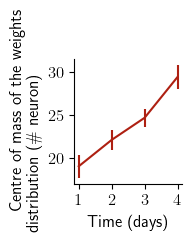

In [38]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(40*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


ax.errorbar([1,2,3,4],np.mean(WoutL,axis=0),stats.sem(WoutL),color = color[8])


ax.set_xlabel(r'Time (days)')
ax.set_ylabel(r'Centre of mass of the weights \newline distribution (\# neuron)')
#ax.set_yticks([0,5,10])
ax.set_xticks([1,2,3,4])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr_sparsity.pdf',bbox_inches='tight')



### Ordinal time decoder, run different E, get t_mat

In [103]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))

In [104]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [105]:
seedL = np.arange(0,10,1)
seedL

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [106]:
EL = [0,.2,.4,.6,.8,1]
EL = np.arange(0,3.2,.5)
Nseed = len(seedL)
EL

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ])

In [ ]:
t_mat = []
t_mat_shuffled = []
V_list = np.zeros([4,N,Nseed])
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    

     # initialisation
    np.random.seed(seed)
    
    mask = np.random.randint(2, size=(N, N))

    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)
    

    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]

    
    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V = np.array([V0,V1,V2,V3])
    V_list[:,:,seed] = V

    np.save("V_list.npy", V_list)

    # decoder ordinal
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            #print(V[perm[i],:])
            s += correlation(V[perm[i],:],V[perm[i+1],:])
        s = s
        s_corr.append(s)
    #print(s_corr)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    # shuffle
    
    V_list_shuffled = np.copy(V_list[:,:,seed])
    #np.random.shuffle(V_list_suffled.T)
    for i in range(N):
        line = np.copy(V[:,i])
        np.random.shuffle(line)
        V_list_shuffled[:,i] = line
    
    #print(V_list[:,:,seed] == V_list_suffled)

    #print(V_list)
    #print(V_list_suffled)
    
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list_shuffled[perm[i],:],V_list_shuffled[perm[i+1],:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_shuffled.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    #plot_all()
    #plt.savefig(str(E)+'all.pdf')

    plt.show()
    




In [109]:
#np.save("t_mat_sparsity.npy", t_mat)
#np.save("t_mat_shuffled_sparsity.npy", t_mat_shuffled)
#t_mat = np.load("t_mat_sparsity.npy")
#t_mat_shuffled = np.load("t_mat_shuffled_sparsity.npy")

In [110]:
t_mat = np.array(t_mat).reshape((len(EL),len(decayL),len(seedL)))
t_mat_shuffled = np.array(t_mat_shuffled).reshape((len(EL),len(decayL),len(seedL)))

decay = 0
t_mat = t_mat[:,decay,:]
t_mat_shuffled = t_mat_shuffled[:,decay,:]

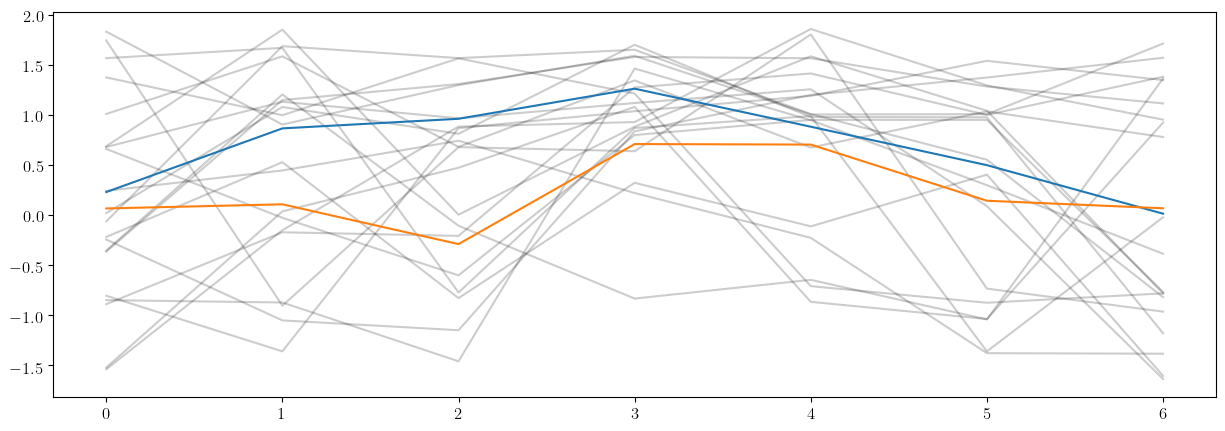

In [111]:
Nseed = len(seedL)
plt.figure(figsize = (15,5))
for seed in range(Nseed):
    plt.plot(t_mat[:,seed],'k', alpha = .2)
    plt.plot(t_mat_shuffled[:,seed],'k', alpha = .2)
plt.plot(np.mean(t_mat,axis = 1))
plt.plot(np.mean(t_mat_shuffled,axis = 1))
#plt.xticks(range(len(EL)),lab);

### figure

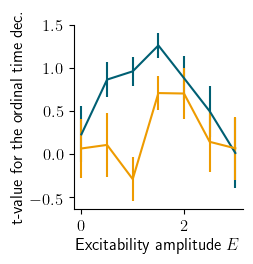

In [112]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,60*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat,axis = 1),stats.sem(t_mat,axis = 1),color = color[1])
ax.errorbar(EL,np.mean(t_mat_shuffled,axis = 1),stats.sem(t_mat_shuffled,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('tVSE_sparsity.pdf',dpi = 1000,bbox_inches='tight')



## Revision: 2 memories with output

In [39]:
decayout = 1000

In [40]:
def run(INPUT):
    global theta
    theta = 0
    global step
    step = 0
    thetaL=np.zeros((N,1))
    y0 = np.concatenate((r0,W0,exc0,theta0,Wout0))
    y = np.zeros((len(y0),nstep))
    routbis = np.zeros((4,nstep))

    y[:,0] = y0
    
    for step in range(nstep-1):
        y[:,step+1] = (y[:,step] + dt * f(y[:,step],dt*step,tag,dt)[np.newaxis]);
    return y


In [41]:
# main function
nstep = 25000
routbis = np.zeros((4,nstep,2))
S = []
def f(yt,t,tag,dt):
    
    global theta
    global routbis
    global routbis_shuffled
    
    r = yt[index[0]][np.newaxis].T
    r = r*(r>1e-5)
    W = yt[index[1]].reshape((N,N))
    
    #rout = yt[index[5]][np.newaxis].T
    #exc =   yt[index[2]][np.newaxis].T
    exc = Emat[:,t][np.newaxis].T

    theta = yt[index[3]][np.newaxis].T

    rinhib = I0 + np.sum(r)*I1 + np.sum(np.multiply(np.maximum(0,r),r))*.05

    drdt = (-r + np.maximum(0,W.dot(r) + INPUT(t,ctxA,seqA)[np.newaxis].T + INPUT(t,ctxB,seqB)[np.newaxis].T - rinhib + exc ) )/taur

    dthetadt = np.zeros(N)
    dthetadt = ( r/y0 - theta ) / tautheta
    
    #dWdt = np.tanh(r.dot((r-theta).T)) / tauw - W/decay
    
    #dWdt = np.tanh(r.dot((r-0).T)) / tauw - W/decay
    dWdt = r.dot(r.T) / tauw - W/decay
    dWdt = np.multiply(dWdt,np.logical_not(np.logical_or(np.logical_and(W>=cap,dWdt>0),np.logical_and(W<=0,dWdt<0))))
    #drdt = np.multiply(drdt,np.logical_not(np.logical_or(np.logical_and(r>=10,drdt>0),np.logical_and(r<=0,drdt<0))))


    
    # excitability
    dexcdt = np.zeros(N)
    
    if t == 2900 or t == 5900 or t == 8900 or t == 11900:
            active = np.maximum(0,r-threshold)>0
            L = np.where(active)[0]
            #print(np.where(active)[0])
    
    
    dWoutdt = np.zeros((N,2))
    for memory in range(2):
        Wout = yt[index[4]].reshape((N,2))[:,memory]
        
        rout = Wout.dot(r)[0] 
        
        if t > 1000 and t < 3000 and memory == 0:
            rout += .1
        if t > 4000 and t < 6000 and memory == 1:
            rout += .1
            
        routbis[0,t,memory] = rout

        dWoutdt[:,memory] = (1 - np.sum(Wout))*r.T * rout/200 - Wout/decayout

    
            
        dWoutdt[:,memory] = np.multiply(dWoutdt[:,memory],np.logical_not(np.logical_and(Wout<=0,dWoutdt[:,memory]<0)))




        S.append(np.sum(Wout))

        if t > 6500:
            Wout = Wout.T
            np.random.shuffle(Wout)
            Wout = Wout.T
            routbis[1,t,memory] = Wout.dot(r)[0]

        if t > 13500:
            Wout = Wout.T
            np.random.shuffle(Wout)
            Wout = Wout.T
            routbis[2,t,memory] = Wout.dot(r)[0]

        if t > 20500:
            Wout = Wout.T
            np.random.shuffle(Wout)
            Wout = Wout.T
            routbis[3,t,memory] = Wout.dot(r)[0]
        
    dydt = np.concatenate((drdt.flatten(),
                           dWdt.reshape((N*N)).flatten(),
                           dexcdt.flatten(),
                           dthetadt.flatten(),
                           dWoutdt.flatten()
                           ))

    return dydt

In [42]:
N = 50
I0 = 5
I1 = 1
E = 5
#taus = 2000

taur = 50
tauw = 1000
tautheta = 800
y0 = 10
r0 = np.zeros(N)
W0 = np.zeros(N*N)
Wout0 = np.zeros(N*2) + 0


In [43]:
nstep = 25000
dt = 1
IN = 15
Nstim = 10
stim = 200
duration = 100
pause = 1000
delay = 3000
tag = 0

seqA = []
seqB = []
Nevent = 4
for ev in range(Nevent):

    for i in range(Nstim):
        seqA.append(pause + i*stim + 2*delay*ev)
        seqA.append(pause + i*stim + duration + 2*delay*ev)
        
    for i in range(Nstim):
        seqB.append(pause + i*stim + delay + 2*delay*ev)
        seqB.append(pause + i*stim + duration + delay + 2*delay*ev)


def INPUT(t,ctx,seq):
    L = 0
    pol = 1
    for step in seq:
        L += np.tanh(t-step)*pol
        pol *= -1
    return IN * ctx * L/2 + 1

 

In [44]:
index = [range(0,N),
         range(N,N + N*N),
         range(N + N*N,N + N*N +N),
         range(N + N*N +N,N + N*N+N+N),
         range(N + N*N +N+N,N + N*N +N+N+N*2)]

In [45]:
def def_Emat(E,exc0):
    Emat = np.zeros((N,nstep))
    Emat[:5,:] = 0
    Emat[10:20,:6500] = E
    Emat[20:30,6500:12500] = E
    Emat[30:40,12500:18500] = E
    Emat[40:50,18500:] = E
    Emat += np.repeat(exc0[np.newaxis], nstep,axis=0).T
    return(Emat)

#Emat = Emat(E,exc0)
#plt.imshow(Emat,aspect = nstep/N/2)


In [46]:
threshold = 5
decayL = [4000]
tauwL = [800]
taurL = [20]
tauthetaL = [100]
I0L = [8]
I1L = [.8]
EL = [1.5]
y0L = [2]
sigmaL = [1]
INL = [12]
seedL = [7]
cap = 1


(tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed)= (tauwL[0],taurL[0],tauthetaL[0],I0L[0],I1L[0],EL[0],y0L[0],sigmaL[0],decayL[0],INL[0],seedL[0])


In [47]:
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    random.seed(seed)
    
    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    random.shuffle(ctxA)
    ctxB = 1 - ctxA


    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    #exc0 = np.random.uniform(0,sigma,N)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:]
    
    
    #plot_all()
    #plt.savefig('all.pdf')

    plt.show()
 





(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 7)


### figure

In [48]:
active = r[:,2850]>threshold
active2 = r[:,5850]>threshold
active = np.where(active)[0]
active2 = np.where(active2)[0]

In [49]:
np.concatenate((active,active2))

array([16, 23, 27, 45, 10, 15, 19, 47])

In [50]:
nonactive = [i for i in range(N) if i not in np.concatenate((active,active2))]

In [51]:
cmap = reversed(["20331a","33512a","446c37","558745","66a253","7cb36b","94c186","abcea1","c3dcbc","dbead7"])
cmap2 = ["ffffff","005F73"]

In [52]:
import matplotlib.colors as mcolors
def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]


def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp

cmap = get_continuous_cmap(cmap)
cmap2 = get_continuous_cmap(cmap2)

In [53]:
def plot_2memories(ctx = 'A', seq = seqA):
    mm = 1/2.54/10 
    fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
    rc('text', usetex=True)
    rc('font',**fontProperties)
    fig = plt.figure(figsize=(160*mm,160*mm), facecolor='w',frameon=False)

    ax1 = fig.add_axes([.04,.79,.88,.2]) # [left, bottom, width, height] 
    ax2 = fig.add_axes([.04,.56,.88,.2])
    ax3 = fig.add_axes([.08,.33,.8,.2])

    w = .18
    ax5 = fig.add_axes([.08,.06,w,w])
    ax6 = fig.add_axes([.285,.06,w,w])
    ax7 = fig.add_axes([.49,.06,w,w])
    ax8 = fig.add_axes([.695,.06,w,w])


    im = ax1.imshow(Emat[:,:25000],aspect = 25000/N*2/8,cmap = cmap)
    ax1.set_ylabel('Neurons')
    ax1.set_xticklabels('')
    cbar1 = plt.colorbar(im,cax = plt.axes([.9, 0.79, 0.01, 0.2])) # [left, bottom, width, height] 
    cbar1.ax.set_title('Excitability (a.u.)', rotation=270,loc='left',y=-.09,x=6)

    im = ax2.imshow(r[:,:25000],aspect = 25000/N*2/8,cmap = cmap2)
    ax2.set_ylabel('Neurons')
    ax2.set_xticklabels('')
    cbar2 = plt.colorbar(im,cax = plt.axes([.9, 0.56, 0.01, 0.2])) # [left, bottom, width, height] 
    cbar2.ax.set_title('Firing rate (a.u)', rotation=270,loc='left',y=-.09,x=6)

    for n in active:
        ax3.plot(r[n,:],color[8],linewidth = 1)
    for n in active2:
        ax3.plot(r[n,:],color = '#558745',linewidth = 1)
    for n in nonactive:
        ax3.plot(r[n,:],color[1],linewidth = 1)


    ax3.axhline(threshold,color='k',linestyle='--',linewidth = 1)
    ax3.set_xlabel('Time (a.u.)')
    ax3.set_ylabel('Firing rate (a.u.)')

    ax3.set_xlim([0,25000])
    ax3.set_ylim([-1,9])

    h = -.5
    for s in range(int(len(seq)/2)):
        ax3.plot([seq[2*s],seq[2*s+1]],[h,h],'k')

    if ctx == 'A':
        im = ax5.imshow(y[index[1][:],3000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax6.imshow(y[index[1][:],9000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax7.imshow(y[index[1][:],15000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax8.imshow(y[index[1][:],21000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
    else:
        im = ax5.imshow(y[index[1][:],6000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax6.imshow(y[index[1][:],12000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax7.imshow(y[index[1][:],18000].reshape((N,N)),vmin = 0,vmax = 1,cmap= 'binary')
        im = ax8.imshow(y[index[1][:],24000].reshape((N,N))  ,vmin = 0,vmax = 1,cmap= 'binary')
        
    ax6.set_yticklabels('')
    ax7.set_yticklabels('')
    ax8.set_yticklabels('')

    cbar3 = plt.colorbar(im,cax = plt.axes([.9, 0.06, 0.01, 0.18]))
    cbar3.ax.set_title('Weights (a.u)', rotation=270,loc='left',y=-.02,x=6)
    cbar3.set_ticks([0,1])
    plt.savefig('all'+ctx+'.pdf')

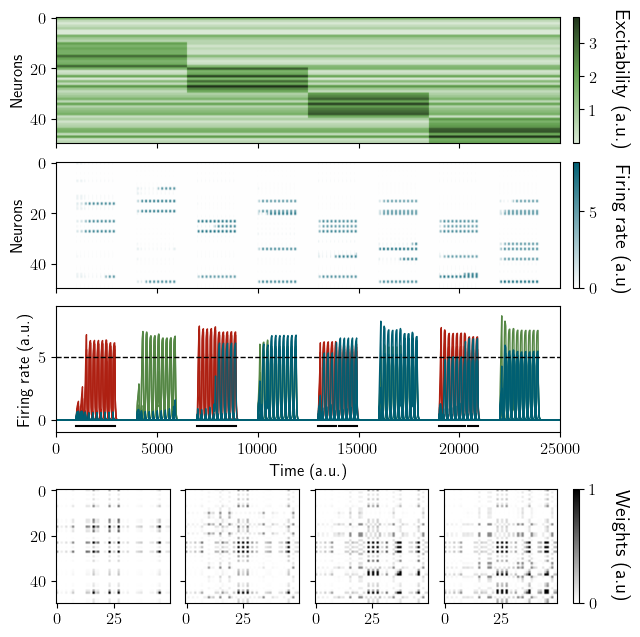

In [54]:
plot_2memories(ctx = 'A', seq = seqA)

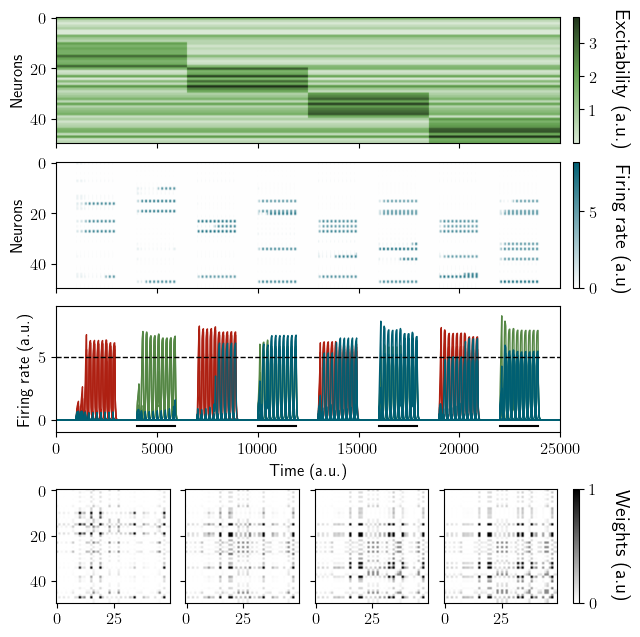

In [55]:
plot_2memories(ctx = 'B', seq = seqB)

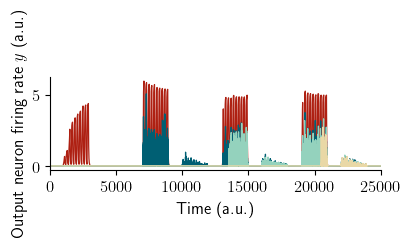

In [56]:
memory = 0

mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(100*mm,30*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.16,0.18,.84,.79])

lw = .9
ax.plot(routbis[0,:,memory],color[8] ,linewidth=lw);
ax.plot(routbis[1,:,memory],color[1],linewidth=lw);
ax.plot(routbis[2,:,memory],color[3],linewidth=lw);
ax.plot(routbis[3,:,memory],color[4],linewidth=lw);

#plt.yscale('log')
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Output neuron firing rate $y$ (a.u.)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,25000])
plt.savefig('decode_rate_A.pdf',bbox_inches='tight')




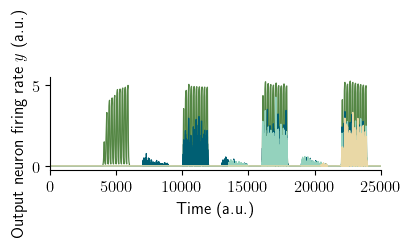

In [57]:
memory = 1

mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(100*mm,30*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.16,0.18,.84,.79])

lw = .9
ax.plot(routbis[0,:,memory],'#558745',linewidth=lw);
ax.plot(routbis[1,:,memory],color[1],linewidth=lw);
ax.plot(routbis[2,:,memory],color[3],linewidth=lw);
ax.plot(routbis[3,:,memory],color[4],linewidth=lw);

#plt.yscale('log')
ax.set_xlabel('Time (a.u.)')
ax.set_ylabel('Output neuron firing rate $y$ (a.u.)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim([0,25000])
plt.savefig('decode_rate_B.pdf',bbox_inches='tight')




In [58]:
Wout = Wout.reshape((N,2,nstep))
WoutL = np.zeros((N,2,8))
for memory in [0,1]:
    W0 = Wout[:,memory,2900]
    W1 = Wout[:,memory,5900]
    W2 = Wout[:,memory,8900]
    W3 = Wout[:,memory,11900]
    W4 = Wout[:,memory,14900]
    W5 = Wout[:,memory,17900]
    W6 = Wout[:,memory,20900]
    W7 = Wout[:,memory,23900]
    
    WoutL[:,memory,:] = np.array([W0,W1,W2,W3,W4,W5,W6,W7]).T

V0 = r[:,2900]
V1 = r[:,5900]
V2 = r[:,8900]
V3 = r[:,11900]
V4 = r[:,14900]
V5 = r[:,17900]
V6 = r[:,20900]
V7 = r[:,23900]
V = np.array([V0,V1,V2,V3,V4,V5,V6,V7])
    

### figure


In [59]:
Wout = Wout.reshape((N,2,nstep))

In [60]:
pos = np.array(range(N))
pos

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [61]:
seedL = range(10)
track = np.zeros((len(seedL),2,8))
for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed))
    
    
     # initialisation
    np.random.seed(seed)
    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)

    Emat = def_Emat(E,exc0)

    # run
    y = run(INPUT)
    exc = y[index[2][:],:]
    r = y[index[0][:],:]
    theta = y[index[3][:],:]
    Wout = y[index[4][:],:].reshape((N,2,nstep))
    
    for memory in [0,1]:
        W0 = Wout[:,memory,2900]
        W1 = Wout[:,memory,5900]
        W2 = Wout[:,memory,8900]
        W3 = Wout[:,memory,11900]
        W4 = Wout[:,memory,14900]
        W5 = Wout[:,memory,17900]
        W6 = Wout[:,memory,20900]
        W7 = Wout[:,memory,23900]

        track[seed,memory,:] = np.array([sum(np.multiply(W0,pos))/np.sum(W0),
                                          sum(np.multiply(W1,pos))/np.sum(W1),
                                          sum(np.multiply(W2,pos))/np.sum(W2),
                                          sum(np.multiply(W3,pos))/np.sum(W3),
                                          sum(np.multiply(W4,pos))/np.sum(W4),
                                          sum(np.multiply(W5,pos))/np.sum(W5),
                                          sum(np.multiply(W6,pos))/np.sum(W6),
                                          sum(np.multiply(W7,pos))/np.sum(W7)])



(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 0)


/tmp/ipykernel_34879/856653881.py:36: RuntimeWarning: invalid value encountered in double_scalars
  track[seed,memory,:] = np.array([sum(np.multiply(W0,pos))/np.sum(W0),


(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 1)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 2)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 3)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 4)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 5)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 6)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 7)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 8)
(800, 20, 100, 8, 0.8, 1.5, 2, 1, 4000, 12, 9)


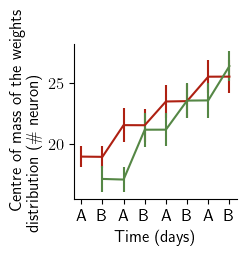

In [62]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
fig = plt.figure(figsize=(60*mm,50*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.26,0.2,.69,.79])


ax.errorbar(range(8),np.mean(track[:,0,:],axis=0),stats.sem(track[:,0,:]),color = color[8])
ax.errorbar(range(8),np.mean(track[:,1,:],axis=0),stats.sem(track[:,1,:]),color = '#558745')


ax.set_xlabel(r'Time (days)')
ax.set_ylabel(r'Centre of mass of the weights \newline distribution (\# neuron)')
#ax.set_yticks([0,5,10])
ax.set_xticks(range(8))
ax.set_xticklabels(['A','B','A','B','A','B','A','B','A','B'])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('decode_corr.pdf',bbox_inches='tight')



### VList and correlations

In [63]:
Nseed = 10
V_list = np.zeros([8,N,Nseed])
for seed in range(Nseed):
    print(seed)
    
     # initialisation
    np.random.seed(seed)
    random.seed(seed)
    
    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    random.shuffle(ctxA)
    ctxB = 1 - ctxA


    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)


    # run
    y = run(INPUT)
    r = y[index[0][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V4 = r[:,14900]
    V5 = r[:,17900]
    V6 = r[:,20900]
    V7 = r[:,23900]
    V = np.array([V0,V1,V2,V3,V4,V5,V6,V7])
    V_list[:,:,seed] = V
        
    #plot_2memories(ctx = 'A')
    #plt.show()
    #plot_2memories(ctx = 'B')
    #plt.show()
    
#np.save("V_list_2memories.npy", V_list)

0
1
2
3
4
5
6
7
8
9


In [64]:
#V_list = np.load('V_list_2memories.npy')

In [65]:
np.max(V_list)

7.676620415736611

In [66]:
V_list.shape

(8, 50, 10)

In [67]:
corrA = np.zeros((4,Nseed))
corrB = np.zeros((4,Nseed))
corrAB = np.zeros((4,Nseed))
for day in range(4):
    for seed in range(Nseed):
        corrA[day,seed]  = correlation(V_list[0,:,seed],V_list[day*2,:,seed])
        corrB[day,seed]  = correlation(V_list[1,:,seed],V_list[day*2+1,:,seed])
        corrAB[day,seed] = correlation(V_list[day*2,:,seed],V_list[day*2+1,:,seed])

corrAB

array([[-0.10879372, -0.08681206, -0.09771302, -0.09838968, -0.11104711,
        -0.09808761, -0.09565489, -0.09226703, -0.09825278, -0.09661373],
       [-0.10939289, -0.10997903, -0.1188123 , -0.11080521, -0.11866007,
        -0.10971932, -0.09776439, -0.09718474, -0.1097451 , -0.10887095],
       [-0.12098013, -0.10965071, -0.1083012 , -0.13391899, -0.12025567,
        -0.1407357 , -0.11666598, -0.14408785, -0.1213613 , -0.11917432],
       [-0.14706168, -0.1085176 , -0.12116326, -0.15585071, -0.13587775,
        -0.1473084 , -0.12188588, -0.14610447, -0.12023279, -0.12138041]])

### figure

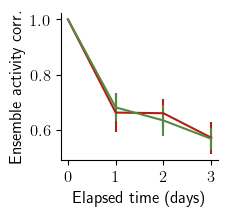

In [68]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,50*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])

ax.errorbar([0,1,2,3], np.mean(corrA,axis=1),stats.sem(corrA,axis = 1), color = color[8])
ax.errorbar([0,1,2,3], np.mean(corrB,axis=1),stats.sem(corrB,axis = 1), color = '#558745')
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr_bis.pdf',bbox_inches='tight')

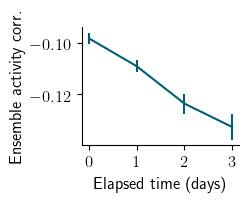

In [69]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(50*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.2,0.2,.8,.75])


ax.errorbar([0,1,2,3], np.mean(corrAB,axis=1),stats.sem(corrAB,axis = 1), color = color[1])
#ax.errorbar([0,1,2,3], np.mean(corr_tot_shuffled,axis=1),stats.sem(corr_tot_shuffled,axis = 1), color = color[1])
ax.set_xlabel('Elapsed time (days)')
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Ensemble activity corr.')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('decay_corr_both_bis.pdf',bbox_inches='tight')

### Ordinal time decoder, run different E, get t_mat

In [73]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))

In [74]:
def correlation(Vi,Vj):
    return(np.sum((Vi-np.mean(Vi))*(Vj-np.mean(Vj))) / np.sqrt(np.sum((Vi-np.mean(Vi))**2)*np.sum((Vj-np.mean(Vj))**2)))

In [75]:
EL = [0,.2,.4,.6,.8,1]
EL = np.arange(0,6,1)
EL = [0]

In [76]:
from itertools import permutations
L = np.array(list(permutations(range(0, 4))))
print(L)

[[0 1 2 3]
 [0 1 3 2]
 [0 2 1 3]
 [0 2 3 1]
 [0 3 1 2]
 [0 3 2 1]
 [1 0 2 3]
 [1 0 3 2]
 [1 2 0 3]
 [1 2 3 0]
 [1 3 0 2]
 [1 3 2 0]
 [2 0 1 3]
 [2 0 3 1]
 [2 1 0 3]
 [2 1 3 0]
 [2 3 0 1]
 [2 3 1 0]
 [3 0 1 2]
 [3 0 2 1]
 [3 1 0 2]
 [3 1 2 0]
 [3 2 0 1]
 [3 2 1 0]]


In [77]:
Nseed = 10
seedL = range(Nseed)
EL = np.arange(0,3.5,.5)
#EL = [0,1.5,3]

#Nseed = 1
#EL = [3]

In [ ]:
V_list_shuffled = np.zeros([8,N])
t_mat_A = []
t_mat_shuffled_A = []
t_mat_B = []
t_mat_shuffled_B = []

for (tauw,taur,tautheta,I0,I1,E,y0,sigma,decay,IN,seed) in itertools.product(tauwL,taurL,tauthetaL,I0L,I1L,EL,y0L,sigmaL,decayL,INL,seedL):
    cc = 0
    print((E,seed))
    
     # initialisation
    np.random.seed(seed)
    random.seed(seed)
    ctxA = np.zeros(N)
    ctxA[:int(N/2)] = 1
    #ctxA = np.zeros(N) + 1
    random.shuffle(ctxA)
    ctxB = 1 - ctxA
    #ctxB = 0


    r0 = np.zeros(N)
    W0 = np.zeros(N*N)
    exc0 = np.zeros(N)
    exc0 = np.random.normal(0,sigma,N)
    exc0 = np.sqrt(exc0*exc0)
    theta0 = np.zeros(N)
    
    Emat = def_Emat(E,exc0)


    # run
    y = run(INPUT)
    r = y[index[0][:],:]


    V0 = r[:,2900]
    V1 = r[:,5900]
    V2 = r[:,8900]
    V3 = r[:,11900]
    V4 = r[:,14900]
    V5 = r[:,17900]
    V6 = r[:,20900]
    V7 = r[:,23900]
    
    V = np.array([V0,V1,V2,V3,V4,V5,V6,V7])
        
        
    active = r[:,2900]>threshold
    active2 = r[:,5900]>threshold
    active = np.where(active)[0]
    active2 = np.where(active2)[0]
    nonactive = [i for i in range(N) if i not in np.concatenate((active,active2))]
    
    #plot_2memories(ctx = 'A')
    #plt.show()
    #plot_2memories(ctx = 'B')
    #plt.show()
    
    

    # decoder ordinal A
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V[2*perm[i],:],V[2*perm[i+1],:])
            #print((2*perm[i],2*perm[i+1]))
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_A.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    
    
    #print(s_corr[0])
    #plt.hist(s_corr)
   # plt.show()
    
    # decoder ordinal B
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V[2*perm[i]+1,:],V[2*perm[i+1]+1,:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_B.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    
    
    
    
    
    #V_list_E[:,:,seed,int(np.where(np.array(EL) == E)[0])] = np.copy(V_list)
    #V_list_suffled = np.copy(V_list)
    #np.random.shuffle(V_list_suffled)
    #V_list_shuffled_E[:,:,seed,int(np.where(np.array(EL) == E)[0])] = np.copy(V_list_suffled)
    
    for i in range(N):
        line = np.copy(V[:,i])
        np.random.shuffle(line)
        V_list_shuffled[:,i] = line
        
    # shuffle A
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            2*perm[i+1]
            s += correlation(V_list_shuffled[2*perm[i],:],V_list_shuffled[2*perm[i+1],:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_shuffled_A.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    # shuffle B
    s_corr = []
    for perm in L:
        s = 0
        for i in range(3):
            s += correlation(V_list_shuffled[2*perm[i]+1,:],V_list_shuffled[2*perm[i+1]+1,:])
        s = s/3
        s_corr.append(s)
    print((s_corr[0]-np.mean(s_corr))/np.std(s_corr))
    t_mat_shuffled_B.append((s_corr[0]-np.mean(s_corr))/np.std(s_corr))

    
    
#np.save("V_list_E.npy", V_list_E)
#np.save("V_list_shuffled_E.npy", V_list_shuffled_E)

In [77]:
#np.save("t_mat_A.npy", t_mat_A)
#np.save("t_mat_B.npy", t_mat_B)
#np.save("t_mat_shuffled_A.npy", t_mat_shuffled_A)
#np.save("t_mat_shuffled_B.npy", t_mat_shuffled_B)
#t_mat_A = np.load("t_mat_A.npy")
#t_mat_B = np.load("t_mat_B.npy")
#t_mat_shuffled_A = np.load("t_mat_shuffled_A.npy")
#t_mat_shuffled_B = np.load("t_mat_shuffled_B.npy")

In [78]:
t_mat_A = np.array(t_mat_A).reshape((len(EL),len(decayL),len(seedL)))
t_mat_shuffled_A = np.array(t_mat_shuffled_A).reshape((len(EL),len(decayL),len(seedL)))
t_mat_B = np.array(t_mat_B).reshape((len(EL),len(decayL),len(seedL)))
t_mat_shuffled_B = np.array(t_mat_shuffled_B).reshape((len(EL),len(decayL),len(seedL)))

decay = 0
#t_mat_A = np.abs(t_mat_A[:,decay,:])
#t_mat_shuffled_A = np.abs(t_mat_shuffled_A[:,decay,:])
#t_mat_B = np.abs(t_mat_B[:,decay,:])
#t_mat_shuffled_B = np.abs(t_mat_shuffled_B[:,decay,:])

t_mat_A = t_mat_A[:,decay,:]
t_mat_shuffled_A = t_mat_shuffled_A[:,decay,:]
t_mat_B = t_mat_B[:,decay,:]
t_mat_shuffled_B = t_mat_shuffled_B[:,decay,:]

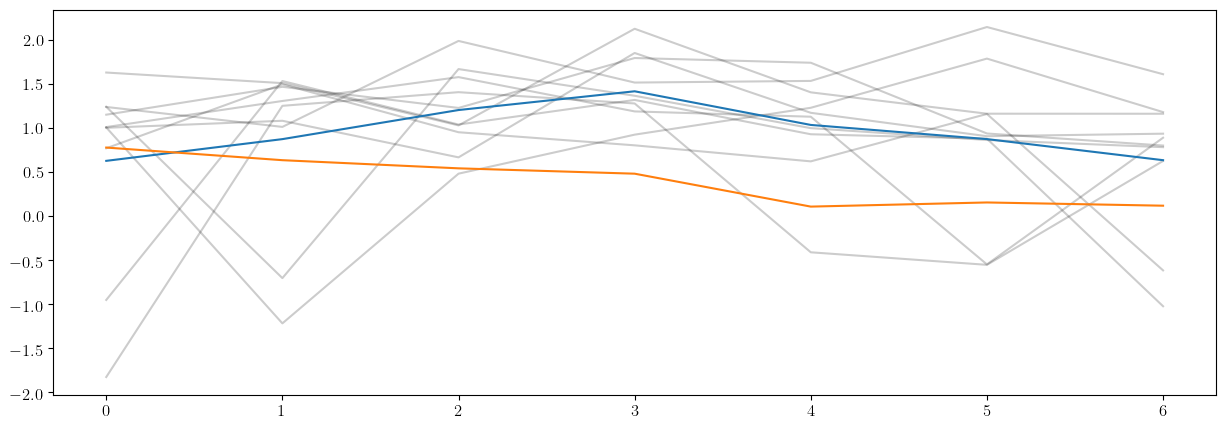

In [79]:
Nseed = len(seedL)
plt.figure(figsize = (15,5))
for seed in range(Nseed):
    plt.plot(t_mat_A[:,seed],'k', alpha = .2)
plt.plot(np.mean(t_mat_A,axis = 1))
plt.plot(np.mean(t_mat_shuffled_A,axis = 1))
#plt.xticks(range(len(EL)),lab);

### figure

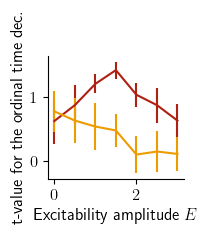

In [80]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(40*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat_A,axis = 1),stats.sem(t_mat_A,axis = 1),color = color[8])
ax.errorbar(EL,np.mean(t_mat_shuffled_A,axis = 1),stats.sem(t_mat_shuffled_A,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0.2,2.1)

plt.savefig('tVSEa2.pdf',dpi = 1000,bbox_inches='tight')



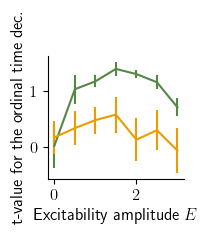

In [81]:
mm = 1/2.54/10 
fontProperties = {'family':'sans-serif','weight' : 'normal', 'size' : 12}
rc('text', usetex=True)
rc('font',**fontProperties)
fig = plt.figure(figsize=(40*mm,40*mm), facecolor='w',frameon=False)
ax = fig.add_axes([0.13,0.2,.86,.78])


Nseed = len(seedL)
ax.errorbar(EL,np.mean(t_mat_B,axis = 1),stats.sem(t_mat_B,axis = 1),color = '#558745')
ax.errorbar(EL,np.mean(t_mat_shuffled_B,axis = 1),stats.sem(t_mat_shuffled_B,axis = 1),color = color[5])
ax.set_ylabel('t-value for the ordinal time dec.')
ax.set_xlabel(r'Excitability amplitude $E$')
#plt.legend(['real data','shuffled data'])
#for seed in range(Nseed):
#    ax.plot(EL,t_mat[:,seed],color = color[0], alpha = .1)

#for seed in range(Nseed):
#    plt.plot(EL,t_mat_shuffled[:,seed],color = color[5], alpha = .2)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_ylim(0.2,2.1)
plt.savefig('tVSEb2.pdf',dpi = 1000,bbox_inches='tight')

